In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:

configs.data_name = data_name



In [7]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [8]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [9]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [10]:
data_name

'dd_fix_stats_demo'

In [11]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [12]:


data_name



'dd_fix_stats_demo'

In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,8,645.693750,283.247212,537.731250,5.683393,147.500000,78.438086,1,4,10,23,102.0
1,1,10,5,8,644.781081,202.020928,524.345946,8.486152,180.810811,88.588574,1,4,10,23,102.0
2,1,10,6,9,708.334615,292.435973,536.546154,7.099140,187.961538,130.054290,1,4,10,23,102.0
3,1,10,7,8,676.047619,317.074279,535.933333,6.465627,179.761905,73.502996,1,4,10,23,102.0
4,1,10,8,8,440.215000,235.935556,541.580000,5.290667,201.800000,91.100638,1,4,10,23,102.0


In [14]:
df_data_to_use.shape

(9071, 15)

In [15]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [16]:

x_org.head()



,Grade_1,Sex_1,Grade_2,FIX_X_std,Word_Number,IQ,Age,FIX_DURATION_mean,FIX_X_mean,FIX_DURATION_std,Grade_3,Grade_4,FIX_Y_mean,Grade_5,FIX_Y_std,Sex_2,Grade_6
0,0,1,0,283.247212,8,23,10,147.500000,645.693750,78.438086,0,1,537.731250,0,5.683393,0,0
1,0,1,0,202.020928,8,23,10,180.810811,644.781081,88.588574,0,1,524.345946,0,8.486152,0,0
2,0,1,0,292.435973,9,23,10,187.961538,708.334615,130.054290,0,1,536.546154,0,7.099140,0,0
3,0,1,0,317.074279,8,23,10,179.761905,676.047619,73.502996,0,1,535.933333,0,6.465627,0,0
4,0,1,0,235.935556,8,23,10,201.800000,440.215000,91.100638,0,1,541.580000,0,5.290667,0,0


In [17]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [18]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [19]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [20]:
x.shape

(9071, 17)

In [29]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [30]:

for k, v in data.items():
    print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

1 (8163, 17) (908, 17)
2 (8164, 17) (907, 17)
3 (8164, 17) (907, 17)
4 (8164, 17) (907, 17)
5 (8164, 17) (907, 17)
6 (8164, 17) (907, 17)
7 (8164, 17) (907, 17)
8 (8164, 17) (907, 17)
9 (8164, 17) (907, 17)
10 (8164, 17) (907, 17)
11 (8617, 17) (454, 17)
12 (8618, 17) (453, 17)
13 (8618, 17) (453, 17)
14 (8618, 17) (453, 17)
15 (8618, 17) (453, 17)
16 (8618, 17) (453, 17)
17 (8618, 17) (453, 17)
18 (8618, 17) (453, 17)
19 (8618, 17) (453, 17)
20 (8618, 17) (453, 17)


## Load the tuned parameters

In [31]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [32]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [33]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [35]:

n_s = str(6)
x_train = data[n_s]["x_train"]
x_test = data[n_s]["x_test"]
y_train = data[n_s]["y_train"]
y_test = data[n_s]["y_test"]



In [36]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

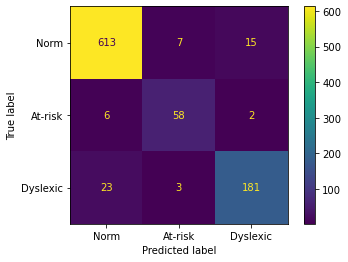

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


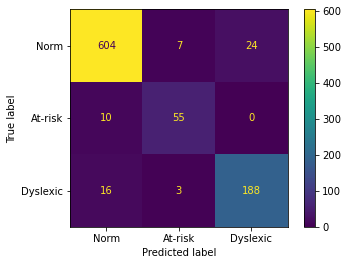

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


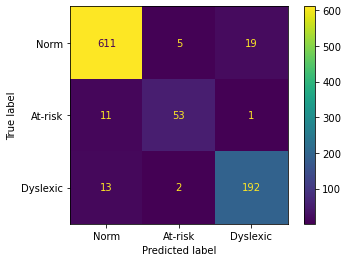

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


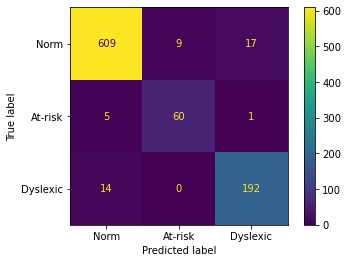

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


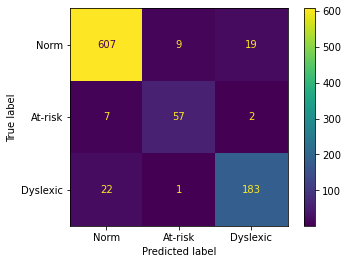

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


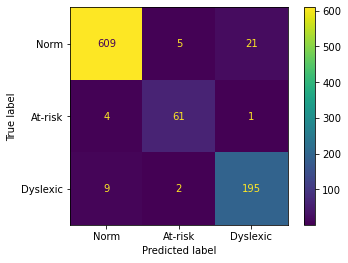

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


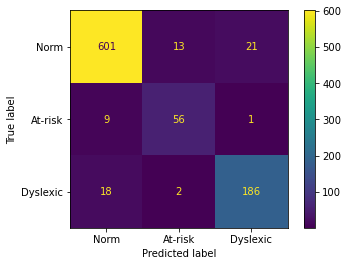

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


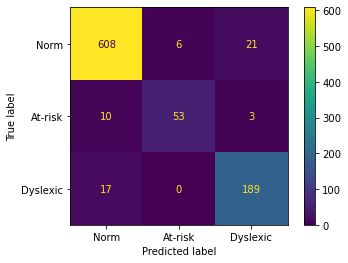

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


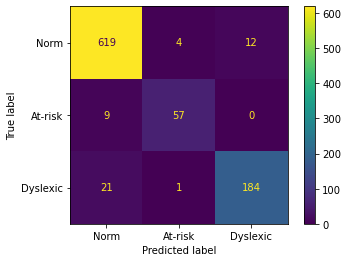

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


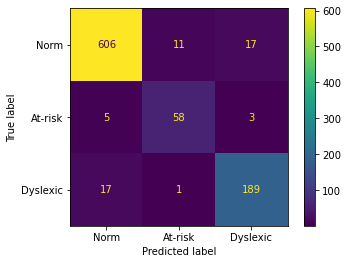

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [37]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [39]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.070 0.110 0.088 0.005 0.941 0.007 0.929 0.013


In [40]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06045D-01    |proj g|=  2.20769D-01

At iterate    1    f=  7.99715D-01    |proj g|=  2.25598D-02

At iterate    2    f=  7.82209D-01    |proj g|=  2.45026D-02

At iterate    3    f=  7.48379D-01    |proj g|=  3.35262D-02

At iterate    4    f=  7.25981D-01    |proj g|=  1.41023D-02

At iterate    5    f=  7.15216D-01    |proj g|=  2.66905D-02

At iterate    6    f=  7.06927D-01    |proj g|=  1.28614D-02

At iterate    7    f=  6.99479D-01    |proj g|=  1.83537D-02

At iterate    8    f=  6.95168D-01    |proj g|=  1.56874D-02

At iterate    9    f=  6.77069D-01    |proj g|=  2.48382D-02

At iterate   10    f=  6.68070D-01    |proj g|=  1.64928D-02

At iterate   11    f=  6.60890D-01    |proj g|=  2.48043D-02

At iterate   12    f=  6.55757D-01    |proj g|=  2.82439D-02

At iterate   13    f=  6.5

 This problem is unconstrained.



At iterate   27    f=  5.81241D-01    |proj g|=  6.80525D-03

At iterate   28    f=  5.78676D-01    |proj g|=  1.15642D-02

At iterate   29    f=  5.76346D-01    |proj g|=  9.66934D-03

At iterate   30    f=  5.73432D-01    |proj g|=  1.82220D-02

At iterate   31    f=  5.70752D-01    |proj g|=  1.06951D-02

At iterate   32    f=  5.67487D-01    |proj g|=  1.03572D-02

At iterate   33    f=  5.65236D-01    |proj g|=  1.02357D-02

At iterate   34    f=  5.63604D-01    |proj g|=  6.49878D-03

At iterate   35    f=  5.62194D-01    |proj g|=  9.33167D-03

At iterate   36    f=  5.60602D-01    |proj g|=  9.62591D-03

At iterate   37    f=  5.58092D-01    |proj g|=  1.04142D-02

At iterate   38    f=  5.57243D-01    |proj g|=  1.21383D-02

At iterate   39    f=  5.55399D-01    |proj g|=  7.39658D-03

At iterate   40    f=  5.53528D-01    |proj g|=  1.35536D-02

At iterate   41    f=  5.51549D-01    |proj g|=  1.22877D-02

At iterate   42    f=  5.49706D-01    |proj g|=  9.85022D-03

At iter


At iterate  183    f=  3.78026D-01    |proj g|=  7.73620D-03

At iterate  184    f=  3.76408D-01    |proj g|=  8.20084D-03

At iterate  185    f=  3.75726D-01    |proj g|=  6.78177D-03

At iterate  186    f=  3.75009D-01    |proj g|=  5.81399D-03

At iterate  187    f=  3.74077D-01    |proj g|=  4.96148D-03

At iterate  188    f=  3.73011D-01    |proj g|=  5.49121D-03

At iterate  189    f=  3.72514D-01    |proj g|=  1.23213D-02

At iterate  190    f=  3.71474D-01    |proj g|=  6.53831D-03

At iterate  191    f=  3.71007D-01    |proj g|=  4.81188D-03

At iterate  192    f=  3.70199D-01    |proj g|=  6.95833D-03

At iterate  193    f=  3.68909D-01    |proj g|=  1.30029D-02

At iterate  194    f=  3.67481D-01    |proj g|=  6.25531D-03

At iterate  195    f=  3.65870D-01    |proj g|=  4.85217D-03

At iterate  196    f=  3.64576D-01    |proj g|=  6.87234D-03

At iterate  197    f=  3.64161D-01    |proj g|=  4.95834D-03

At iterate  198    f=  3.63562D-01    |proj g|=  5.14794D-03

At iter


At iterate  316    f=  2.99268D-01    |proj g|=  3.62397D-03

At iterate  317    f=  2.98733D-01    |proj g|=  5.92177D-03

At iterate  318    f=  2.98186D-01    |proj g|=  6.27979D-03

At iterate  319    f=  2.97727D-01    |proj g|=  6.46772D-03

At iterate  320    f=  2.97289D-01    |proj g|=  4.49449D-03

At iterate  321    f=  2.96863D-01    |proj g|=  5.09856D-03

At iterate  322    f=  2.96457D-01    |proj g|=  3.60191D-03

At iterate  323    f=  2.96142D-01    |proj g|=  3.24827D-03

At iterate  324    f=  2.95676D-01    |proj g|=  5.76170D-03

At iterate  325    f=  2.95262D-01    |proj g|=  1.06018D-02

At iterate  326    f=  2.94602D-01    |proj g|=  6.35758D-03

At iterate  327    f=  2.94139D-01    |proj g|=  6.03924D-03

At iterate  328    f=  2.93533D-01    |proj g|=  4.39816D-03

At iterate  329    f=  2.92864D-01    |proj g|=  5.41810D-03

At iterate  330    f=  2.92624D-01    |proj g|=  9.44540D-03

At iterate  331    f=  2.92170D-01    |proj g|=  3.48257D-03

At iter

At iterate  450    f=  2.51572D-01    |proj g|=  4.37811D-03

At iterate  451    f=  2.51384D-01    |proj g|=  3.28676D-03

At iterate  452    f=  2.51124D-01    |proj g|=  4.22245D-03

At iterate  453    f=  2.50873D-01    |proj g|=  3.43623D-03

At iterate  454    f=  2.50450D-01    |proj g|=  7.46341D-03

At iterate  455    f=  2.49937D-01    |proj g|=  3.60096D-03

At iterate  456    f=  2.49627D-01    |proj g|=  3.12361D-03

At iterate  457    f=  2.49310D-01    |proj g|=  7.78910D-03

At iterate  458    f=  2.49009D-01    |proj g|=  3.35672D-03

At iterate  459    f=  2.48652D-01    |proj g|=  5.33197D-03

At iterate  460    f=  2.48074D-01    |proj g|=  6.56077D-03

At iterate  461    f=  2.47819D-01    |proj g|=  7.49976D-03

At iterate  462    f=  2.47527D-01    |proj g|=  3.87311D-03

At iterate  463    f=  2.47257D-01    |proj g|=  3.10013D-03

At iterate  464    f=  2.47025D-01    |proj g|=  5.48250D-03

At iterate  465    f=  2.46685D-01    |proj g|=  3.02367D-03

At itera


At iterate  583    f=  2.19387D-01    |proj g|=  2.44950D-03

At iterate  584    f=  2.19179D-01    |proj g|=  3.10035D-03

At iterate  585    f=  2.18947D-01    |proj g|=  1.03952D-02

At iterate  586    f=  2.18674D-01    |proj g|=  4.36649D-03

At iterate  587    f=  2.18510D-01    |proj g|=  2.05693D-03

At iterate  588    f=  2.18291D-01    |proj g|=  3.28259D-03

At iterate  589    f=  2.18049D-01    |proj g|=  3.60412D-03

At iterate  590    f=  2.17874D-01    |proj g|=  1.06158D-02

At iterate  591    f=  2.17640D-01    |proj g|=  4.30332D-03

At iterate  592    f=  2.17456D-01    |proj g|=  3.78337D-03

At iterate  593    f=  2.17224D-01    |proj g|=  4.05682D-03

At iterate  594    f=  2.16831D-01    |proj g|=  7.54368D-03

At iterate  595    f=  2.16684D-01    |proj g|=  1.04102D-02

At iterate  596    f=  2.16390D-01    |proj g|=  2.73866D-03

At iterate  597    f=  2.16253D-01    |proj g|=  2.56383D-03

At iterate  598    f=  2.16000D-01    |proj g|=  4.45815D-03

At iter


At iterate  750    f=  1.84994D-01    |proj g|=  3.46580D-03

At iterate  751    f=  1.84831D-01    |proj g|=  2.37237D-03

At iterate  752    f=  1.84799D-01    |proj g|=  1.04345D-02

At iterate  753    f=  1.84532D-01    |proj g|=  2.74423D-03

At iterate  754    f=  1.84460D-01    |proj g|=  1.76932D-03

At iterate  755    f=  1.84309D-01    |proj g|=  2.52240D-03

At iterate  756    f=  1.84152D-01    |proj g|=  4.87887D-03

At iterate  757    f=  1.83913D-01    |proj g|=  4.30647D-03

At iterate  758    f=  1.83727D-01    |proj g|=  4.35121D-03

At iterate  759    f=  1.83626D-01    |proj g|=  3.16722D-03

At iterate  760    f=  1.83492D-01    |proj g|=  2.96285D-03

At iterate  761    f=  1.83345D-01    |proj g|=  4.54349D-03

At iterate  762    f=  1.83200D-01    |proj g|=  3.27106D-03

At iterate  763    f=  1.83069D-01    |proj g|=  1.78882D-03

At iterate  764    f=  1.82972D-01    |proj g|=  2.77226D-03

At iterate  765    f=  1.82839D-01    |proj g|=  3.71759D-03

At iter


At iterate  894    f=  1.65737D-01    |proj g|=  3.39664D-03

At iterate  895    f=  1.65654D-01    |proj g|=  2.58856D-03

At iterate  896    f=  1.65582D-01    |proj g|=  1.68860D-03

At iterate  897    f=  1.65507D-01    |proj g|=  2.97379D-03

At iterate  898    f=  1.65425D-01    |proj g|=  1.62486D-03

At iterate  899    f=  1.65364D-01    |proj g|=  1.70723D-03

At iterate  900    f=  1.65306D-01    |proj g|=  3.67351D-03

At iterate  901    f=  1.65253D-01    |proj g|=  1.84732D-03

At iterate  902    f=  1.65213D-01    |proj g|=  1.15353D-03

At iterate  903    f=  1.65125D-01    |proj g|=  2.25371D-03

At iterate  904    f=  1.65074D-01    |proj g|=  6.22191D-03

At iterate  905    f=  1.65011D-01    |proj g|=  3.34644D-03

At iterate  906    f=  1.64917D-01    |proj g|=  2.13729D-03

At iterate  907    f=  1.64871D-01    |proj g|=  2.92632D-03

At iterate  908    f=  1.64791D-01    |proj g|=  2.28705D-03

At iterate  909    f=  1.64677D-01    |proj g|=  2.99781D-03

At iter


At iterate 1031    f=  1.56223D-01    |proj g|=  3.92030D-03

At iterate 1032    f=  1.56127D-01    |proj g|=  1.99202D-03

At iterate 1033    f=  1.56060D-01    |proj g|=  1.82270D-03

At iterate 1034    f=  1.56010D-01    |proj g|=  6.39859D-03

At iterate 1035    f=  1.55941D-01    |proj g|=  2.58545D-03

At iterate 1036    f=  1.55902D-01    |proj g|=  2.13849D-03

At iterate 1037    f=  1.55841D-01    |proj g|=  2.42604D-03

At iterate 1038    f=  1.55754D-01    |proj g|=  2.38215D-03

At iterate 1039    f=  1.55679D-01    |proj g|=  6.78420D-03

At iterate 1040    f=  1.55571D-01    |proj g|=  3.15069D-03

At iterate 1041    f=  1.55517D-01    |proj g|=  1.27513D-03

At iterate 1042    f=  1.55471D-01    |proj g|=  3.42423D-03

At iterate 1043    f=  1.55425D-01    |proj g|=  2.55546D-03

At iterate 1044    f=  1.55355D-01    |proj g|=  2.17319D-03

At iterate 1045    f=  1.55278D-01    |proj g|=  2.47328D-03

At iterate 1046    f=  1.55192D-01    |proj g|=  2.38866D-03

At iter


At iterate 1185    f=  1.47097D-01    |proj g|=  2.10951D-03

At iterate 1186    f=  1.47064D-01    |proj g|=  1.22627D-03

At iterate 1187    f=  1.47026D-01    |proj g|=  1.32976D-03

At iterate 1188    f=  1.46981D-01    |proj g|=  2.60933D-03

At iterate 1189    f=  1.46933D-01    |proj g|=  1.69162D-03

At iterate 1190    f=  1.46876D-01    |proj g|=  1.27124D-03

At iterate 1191    f=  1.46775D-01    |proj g|=  1.90121D-03

At iterate 1192    f=  1.46759D-01    |proj g|=  8.37524D-03

At iterate 1193    f=  1.46694D-01    |proj g|=  1.87634D-03

At iterate 1194    f=  1.46682D-01    |proj g|=  1.39807D-03

At iterate 1195    f=  1.46645D-01    |proj g|=  2.78495D-03

At iterate 1196    f=  1.46613D-01    |proj g|=  5.14325D-03

At iterate 1197    f=  1.46576D-01    |proj g|=  1.73914D-03

At iterate 1198    f=  1.46555D-01    |proj g|=  1.18180D-03

At iterate 1199    f=  1.46534D-01    |proj g|=  1.28456D-03

At iterate 1200    f=  1.46469D-01    |proj g|=  2.89313D-03

At iter


At iterate 1333    f=  1.40987D-01    |proj g|=  6.48598D-03

At iterate 1334    f=  1.40936D-01    |proj g|=  3.28635D-03

At iterate 1335    f=  1.40896D-01    |proj g|=  1.66139D-03

At iterate 1336    f=  1.40869D-01    |proj g|=  2.26238D-03

At iterate 1337    f=  1.40834D-01    |proj g|=  2.96970D-03

At iterate 1338    f=  1.40770D-01    |proj g|=  4.65172D-03

At iterate 1339    f=  1.40698D-01    |proj g|=  1.77670D-03

At iterate 1340    f=  1.40644D-01    |proj g|=  2.05357D-03

At iterate 1341    f=  1.40617D-01    |proj g|=  6.05941D-03

At iterate 1342    f=  1.40580D-01    |proj g|=  4.22222D-03

At iterate 1343    f=  1.40506D-01    |proj g|=  1.84716D-03

At iterate 1344    f=  1.40455D-01    |proj g|=  3.02272D-03

At iterate 1345    f=  1.40418D-01    |proj g|=  2.04693D-03

At iterate 1346    f=  1.40378D-01    |proj g|=  4.95660D-03

At iterate 1347    f=  1.40320D-01    |proj g|=  2.45746D-03

At iterate 1348    f=  1.40228D-01    |proj g|=  1.45143D-03

At iter


At iterate 1472    f=  1.36089D-01    |proj g|=  1.99702D-03

At iterate 1473    f=  1.36065D-01    |proj g|=  2.18604D-03

At iterate 1474    f=  1.36037D-01    |proj g|=  1.75925D-03

At iterate 1475    f=  1.36005D-01    |proj g|=  1.98913D-03

At iterate 1476    f=  1.35966D-01    |proj g|=  3.59636D-03

At iterate 1477    f=  1.35920D-01    |proj g|=  1.35056D-03

At iterate 1478    f=  1.35888D-01    |proj g|=  9.48061D-04

At iterate 1479    f=  1.35866D-01    |proj g|=  1.43331D-03

At iterate 1480    f=  1.35844D-01    |proj g|=  3.42601D-03

At iterate 1481    f=  1.35816D-01    |proj g|=  1.32991D-03

At iterate 1482    f=  1.35796D-01    |proj g|=  1.36429D-03

At iterate 1483    f=  1.35772D-01    |proj g|=  1.37253D-03

At iterate 1484    f=  1.35755D-01    |proj g|=  6.70347D-03

At iterate 1485    f=  1.35723D-01    |proj g|=  2.32285D-03

At iterate 1486    f=  1.35693D-01    |proj g|=  1.59443D-03

At iterate 1487    f=  1.35659D-01    |proj g|=  2.19727D-03

At iter

At iterate 1628    f=  1.30426D-01    |proj g|=  2.42334D-03

At iterate 1629    f=  1.30401D-01    |proj g|=  1.53444D-03

At iterate 1630    f=  1.30366D-01    |proj g|=  2.32502D-03

At iterate 1631    f=  1.30315D-01    |proj g|=  2.76018D-03

At iterate 1632    f=  1.30299D-01    |proj g|=  8.57726D-03

At iterate 1633    f=  1.30224D-01    |proj g|=  2.73254D-03

At iterate 1634    f=  1.30201D-01    |proj g|=  1.25406D-03

At iterate 1635    f=  1.30175D-01    |proj g|=  2.25610D-03

At iterate 1636    f=  1.30150D-01    |proj g|=  4.82963D-03

At iterate 1637    f=  1.30118D-01    |proj g|=  2.89830D-03

At iterate 1638    f=  1.30066D-01    |proj g|=  1.94466D-03

At iterate 1639    f=  1.30041D-01    |proj g|=  2.28832D-03

At iterate 1640    f=  1.29967D-01    |proj g|=  8.43570D-03

At iterate 1641    f=  1.29928D-01    |proj g|=  7.09324D-03

At iterate 1642    f=  1.29885D-01    |proj g|=  1.68564D-03

At iterate 1643    f=  1.29863D-01    |proj g|=  1.95090D-03

At itera


At iterate 1786    f=  1.24275D-01    |proj g|=  2.50785D-03

At iterate 1787    f=  1.24235D-01    |proj g|=  2.56216D-03

At iterate 1788    f=  1.24205D-01    |proj g|=  1.94625D-03

At iterate 1789    f=  1.24140D-01    |proj g|=  2.57188D-03

At iterate 1790    f=  1.24118D-01    |proj g|=  3.84636D-03

At iterate 1791    f=  1.24083D-01    |proj g|=  2.19280D-03

At iterate 1792    f=  1.24054D-01    |proj g|=  2.29943D-03

At iterate 1793    f=  1.24013D-01    |proj g|=  3.01155D-03

At iterate 1794    f=  1.23979D-01    |proj g|=  6.98640D-03

At iterate 1795    f=  1.23942D-01    |proj g|=  1.62353D-03

At iterate 1796    f=  1.23922D-01    |proj g|=  1.46773D-03

At iterate 1797    f=  1.23885D-01    |proj g|=  3.11408D-03

At iterate 1798    f=  1.23865D-01    |proj g|=  3.52224D-03

At iterate 1799    f=  1.23839D-01    |proj g|=  1.46858D-03

At iterate 1800    f=  1.23822D-01    |proj g|=  2.07245D-03

At iterate 1801    f=  1.23786D-01    |proj g|=  2.31697D-03

At iter


At iterate 1923    f=  1.20010D-01    |proj g|=  6.31946D-03

At iterate 1924    f=  1.19970D-01    |proj g|=  2.18289D-03

At iterate 1925    f=  1.19947D-01    |proj g|=  1.64432D-03

At iterate 1926    f=  1.19923D-01    |proj g|=  1.91862D-03

At iterate 1927    f=  1.19911D-01    |proj g|=  4.11346D-03

At iterate 1928    f=  1.19893D-01    |proj g|=  3.02456D-03

At iterate 1929    f=  1.19862D-01    |proj g|=  1.44365D-03

At iterate 1930    f=  1.19841D-01    |proj g|=  1.94356D-03

At iterate 1931    f=  1.19797D-01    |proj g|=  3.98807D-03

At iterate 1932    f=  1.19772D-01    |proj g|=  2.89141D-03

At iterate 1933    f=  1.19739D-01    |proj g|=  1.51896D-03

At iterate 1934    f=  1.19710D-01    |proj g|=  1.55531D-03

At iterate 1935    f=  1.19678D-01    |proj g|=  1.72644D-03

At iterate 1936    f=  1.19664D-01    |proj g|=  3.74434D-03

At iterate 1937    f=  1.19642D-01    |proj g|=  2.25997D-03

At iterate 1938    f=  1.19613D-01    |proj g|=  1.34777D-03

At iter


At iterate 2060    f=  1.16555D-01    |proj g|=  3.57502D-03

At iterate 2061    f=  1.16527D-01    |proj g|=  2.90433D-03

At iterate 2062    f=  1.16495D-01    |proj g|=  1.85977D-03

At iterate 2063    f=  1.16457D-01    |proj g|=  1.99936D-03

At iterate 2064    f=  1.16442D-01    |proj g|=  7.19837D-03

At iterate 2065    f=  1.16399D-01    |proj g|=  1.64509D-03

At iterate 2066    f=  1.16375D-01    |proj g|=  1.51293D-03

At iterate 2067    f=  1.16345D-01    |proj g|=  2.70757D-03

At iterate 2068    f=  1.16307D-01    |proj g|=  2.22107D-03

At iterate 2069    f=  1.16294D-01    |proj g|=  6.08083D-03

At iterate 2070    f=  1.16263D-01    |proj g|=  1.76098D-03

At iterate 2071    f=  1.16248D-01    |proj g|=  1.45208D-03

At iterate 2072    f=  1.16222D-01    |proj g|=  1.53273D-03

At iterate 2073    f=  1.16206D-01    |proj g|=  3.12731D-03

At iterate 2074    f=  1.16181D-01    |proj g|=  1.58658D-03

At iterate 2075    f=  1.16162D-01    |proj g|=  1.99423D-03

At iter


At iterate 2193    f=  1.13568D-01    |proj g|=  3.94304D-03

At iterate 2194    f=  1.13554D-01    |proj g|=  1.15452D-03

At iterate 2195    f=  1.13543D-01    |proj g|=  1.16273D-03

At iterate 2196    f=  1.13523D-01    |proj g|=  6.43644D-03

At iterate 2197    f=  1.13495D-01    |proj g|=  2.45348D-03

At iterate 2198    f=  1.13478D-01    |proj g|=  1.29872D-03

At iterate 2199    f=  1.13456D-01    |proj g|=  2.19606D-03

At iterate 2200    f=  1.13433D-01    |proj g|=  2.70749D-03

At iterate 2201    f=  1.13422D-01    |proj g|=  5.18561D-03

At iterate 2202    f=  1.13399D-01    |proj g|=  1.37739D-03

At iterate 2203    f=  1.13391D-01    |proj g|=  1.16027D-03

At iterate 2204    f=  1.13382D-01    |proj g|=  1.48520D-03

At iterate 2205    f=  1.13362D-01    |proj g|=  1.87989D-03

At iterate 2206    f=  1.13353D-01    |proj g|=  4.69873D-03

At iterate 2207    f=  1.13334D-01    |proj g|=  1.55264D-03

At iterate 2208    f=  1.13322D-01    |proj g|=  1.04403D-03

At iter


At iterate 2332    f=  1.10988D-01    |proj g|=  2.22227D-03

At iterate 2333    f=  1.10973D-01    |proj g|=  3.54674D-03

At iterate 2334    f=  1.10954D-01    |proj g|=  1.28382D-03

At iterate 2335    f=  1.10933D-01    |proj g|=  2.19464D-03

At iterate 2336    f=  1.10921D-01    |proj g|=  1.31757D-03

At iterate 2337    f=  1.10917D-01    |proj g|=  5.54736D-03

At iterate 2338    f=  1.10893D-01    |proj g|=  1.38671D-03

At iterate 2339    f=  1.10885D-01    |proj g|=  2.05846D-03

At iterate 2340    f=  1.10872D-01    |proj g|=  2.54028D-03

At iterate 2341    f=  1.10851D-01    |proj g|=  2.39184D-03

At iterate 2342    f=  1.10832D-01    |proj g|=  4.45587D-03

At iterate 2343    f=  1.10806D-01    |proj g|=  1.92036D-03

At iterate 2344    f=  1.10796D-01    |proj g|=  8.97451D-04

At iterate 2345    f=  1.10785D-01    |proj g|=  1.85388D-03

At iterate 2346    f=  1.10771D-01    |proj g|=  2.86488D-03

At iterate 2347    f=  1.10750D-01    |proj g|=  3.08958D-03

At iter


At iterate 2470    f=  1.08366D-01    |proj g|=  1.27080D-03

At iterate 2471    f=  1.08345D-01    |proj g|=  2.36582D-03

At iterate 2472    f=  1.08338D-01    |proj g|=  6.79541D-03

At iterate 2473    f=  1.08321D-01    |proj g|=  1.32764D-03

At iterate 2474    f=  1.08314D-01    |proj g|=  9.41444D-04

At iterate 2475    f=  1.08306D-01    |proj g|=  1.99462D-03

At iterate 2476    f=  1.08291D-01    |proj g|=  2.34056D-03

At iterate 2477    f=  1.08262D-01    |proj g|=  2.55038D-03

At iterate 2478    f=  1.08236D-01    |proj g|=  2.96689D-03

At iterate 2479    f=  1.08217D-01    |proj g|=  2.08009D-03

At iterate 2480    f=  1.08204D-01    |proj g|=  1.51167D-03

At iterate 2481    f=  1.08195D-01    |proj g|=  2.14237D-03

At iterate 2482    f=  1.08181D-01    |proj g|=  1.55452D-03

At iterate 2483    f=  1.08170D-01    |proj g|=  1.17007D-03

At iterate 2484    f=  1.08144D-01    |proj g|=  1.94522D-03

At iterate 2485    f=  1.08139D-01    |proj g|=  7.05292D-03

At iter


At iterate 2605    f=  1.06096D-01    |proj g|=  2.63324D-03

At iterate 2606    f=  1.06063D-01    |proj g|=  1.78598D-03

At iterate 2607    f=  1.06051D-01    |proj g|=  2.01139D-03

At iterate 2608    f=  1.06037D-01    |proj g|=  1.50673D-03

At iterate 2609    f=  1.06022D-01    |proj g|=  1.54360D-03

At iterate 2610    f=  1.06002D-01    |proj g|=  1.97668D-03

At iterate 2611    f=  1.05999D-01    |proj g|=  7.94568D-03

At iterate 2612    f=  1.05965D-01    |proj g|=  2.08651D-03

At iterate 2613    f=  1.05955D-01    |proj g|=  1.46290D-03

At iterate 2614    f=  1.05940D-01    |proj g|=  1.69968D-03

At iterate 2615    f=  1.05927D-01    |proj g|=  5.07019D-03

At iterate 2616    f=  1.05908D-01    |proj g|=  1.90015D-03

At iterate 2617    f=  1.05895D-01    |proj g|=  2.03937D-03

At iterate 2618    f=  1.05869D-01    |proj g|=  2.15445D-03

At iterate 2619    f=  1.05839D-01    |proj g|=  1.94745D-03

At iterate 2620    f=  1.05805D-01    |proj g|=  4.10635D-03

At iter


At iterate 2754    f=  1.03477D-01    |proj g|=  8.30042D-03

At iterate 2755    f=  1.03445D-01    |proj g|=  2.12497D-03

At iterate 2756    f=  1.03435D-01    |proj g|=  1.07556D-03

At iterate 2757    f=  1.03427D-01    |proj g|=  5.58844D-03

At iterate 2758    f=  1.03412D-01    |proj g|=  1.30844D-03

At iterate 2759    f=  1.03406D-01    |proj g|=  1.72400D-03

At iterate 2760    f=  1.03390D-01    |proj g|=  1.47848D-03

At iterate 2761    f=  1.03376D-01    |proj g|=  3.81766D-03

At iterate 2762    f=  1.03358D-01    |proj g|=  1.63755D-03

At iterate 2763    f=  1.03348D-01    |proj g|=  1.37006D-03

At iterate 2764    f=  1.03333D-01    |proj g|=  9.81022D-04

At iterate 2765    f=  1.03318D-01    |proj g|=  1.08619D-03

At iterate 2766    f=  1.03313D-01    |proj g|=  2.22045D-03

At iterate 2767    f=  1.03300D-01    |proj g|=  1.25525D-03

At iterate 2768    f=  1.03286D-01    |proj g|=  8.99560D-04

At iterate 2769    f=  1.03271D-01    |proj g|=  4.81227D-03

At iter


At iterate 2889    f=  1.01617D-01    |proj g|=  1.29744D-03

At iterate 2890    f=  1.01609D-01    |proj g|=  1.18579D-03

At iterate 2891    f=  1.01592D-01    |proj g|=  2.45812D-03

At iterate 2892    f=  1.01582D-01    |proj g|=  1.61507D-03

At iterate 2893    f=  1.01572D-01    |proj g|=  9.04138D-04

At iterate 2894    f=  1.01561D-01    |proj g|=  1.25244D-03

At iterate 2895    f=  1.01544D-01    |proj g|=  1.62623D-03

At iterate 2896    f=  1.01535D-01    |proj g|=  3.19694D-03

At iterate 2897    f=  1.01518D-01    |proj g|=  1.67781D-03

At iterate 2898    f=  1.01510D-01    |proj g|=  1.06681D-03

At iterate 2899    f=  1.01507D-01    |proj g|=  4.27494D-03

At iterate 2900    f=  1.01499D-01    |proj g|=  1.64647D-03

At iterate 2901    f=  1.01491D-01    |proj g|=  1.61182D-03

At iterate 2902    f=  1.01483D-01    |proj g|=  2.59776D-03

At iterate 2903    f=  1.01473D-01    |proj g|=  2.02202D-03

At iterate 2904    f=  1.01455D-01    |proj g|=  2.47633D-03

At iter


At iterate 3034    f=  1.00314D-01    |proj g|=  2.19828D-03

At iterate 3035    f=  1.00309D-01    |proj g|=  2.73019D-03

At iterate 3036    f=  1.00302D-01    |proj g|=  1.71671D-03

At iterate 3037    f=  1.00292D-01    |proj g|=  1.20221D-03

At iterate 3038    f=  1.00287D-01    |proj g|=  1.23624D-03

At iterate 3039    f=  1.00278D-01    |proj g|=  3.27702D-03

At iterate 3040    f=  1.00264D-01    |proj g|=  1.68501D-03

At iterate 3041    f=  1.00256D-01    |proj g|=  1.05559D-03

At iterate 3042    f=  1.00246D-01    |proj g|=  1.55830D-03

At iterate 3043    f=  1.00235D-01    |proj g|=  1.73875D-03

At iterate 3044    f=  1.00215D-01    |proj g|=  1.55029D-03

At iterate 3045    f=  1.00206D-01    |proj g|=  3.14241D-03

At iterate 3046    f=  1.00195D-01    |proj g|=  1.13539D-03

At iterate 3047    f=  1.00186D-01    |proj g|=  1.57190D-03

At iterate 3048    f=  1.00184D-01    |proj g|=  4.77509D-03

At iterate 3049    f=  1.00175D-01    |proj g|=  2.11744D-03

At iter

At iterate 3180    f=  9.90475D-02    |proj g|=  9.47426D-04

At iterate 3181    f=  9.90457D-02    |proj g|=  8.44452D-04

At iterate 3182    f=  9.90397D-02    |proj g|=  1.29078D-03

At iterate 3183    f=  9.90382D-02    |proj g|=  3.25375D-03

At iterate 3184    f=  9.90283D-02    |proj g|=  1.13055D-03

At iterate 3185    f=  9.90247D-02    |proj g|=  1.23392D-03

At iterate 3186    f=  9.90179D-02    |proj g|=  1.30615D-03

At iterate 3187    f=  9.90065D-02    |proj g|=  1.87274D-03

At iterate 3188    f=  9.89958D-02    |proj g|=  3.08059D-03

At iterate 3189    f=  9.89856D-02    |proj g|=  1.22401D-03

At iterate 3190    f=  9.89809D-02    |proj g|=  7.77378D-04

At iterate 3191    f=  9.89760D-02    |proj g|=  3.45562D-03

At iterate 3192    f=  9.89694D-02    |proj g|=  1.68973D-03

At iterate 3193    f=  9.89615D-02    |proj g|=  1.14969D-03

At iterate 3194    f=  9.89545D-02    |proj g|=  1.35001D-03

At iterate 3195    f=  9.89492D-02    |proj g|=  2.52615D-03

At itera


At iterate 3317    f=  9.82244D-02    |proj g|=  8.60053D-04

At iterate 3318    f=  9.82221D-02    |proj g|=  7.81430D-04

At iterate 3319    f=  9.82146D-02    |proj g|=  1.02847D-03

At iterate 3320    f=  9.82078D-02    |proj g|=  1.22126D-03

At iterate 3321    f=  9.82001D-02    |proj g|=  1.04148D-03

At iterate 3322    f=  9.81927D-02    |proj g|=  1.83316D-03

At iterate 3323    f=  9.81856D-02    |proj g|=  1.01407D-03

At iterate 3324    f=  9.81811D-02    |proj g|=  8.46954D-04

At iterate 3325    f=  9.81764D-02    |proj g|=  5.31148D-04

At iterate 3326    f=  9.81724D-02    |proj g|=  2.11655D-03

At iterate 3327    f=  9.81679D-02    |proj g|=  1.47069D-03

At iterate 3328    f=  9.81645D-02    |proj g|=  1.69514D-03

At iterate 3329    f=  9.81627D-02    |proj g|=  9.08859D-04

At iterate 3330    f=  9.81604D-02    |proj g|=  8.02646D-04

At iterate 3331    f=  9.81561D-02    |proj g|=  1.27344D-03

At iterate 3332    f=  9.81507D-02    |proj g|=  1.32562D-03

At iter


At iterate 3459    f=  9.74308D-02    |proj g|=  9.62087D-04

At iterate 3460    f=  9.74247D-02    |proj g|=  1.17097D-03

At iterate 3461    f=  9.74226D-02    |proj g|=  2.78615D-03

At iterate 3462    f=  9.74180D-02    |proj g|=  2.06118D-03

At iterate 3463    f=  9.74061D-02    |proj g|=  1.09770D-03

At iterate 3464    f=  9.73977D-02    |proj g|=  1.17257D-03

At iterate 3465    f=  9.73866D-02    |proj g|=  1.25630D-03

At iterate 3466    f=  9.73813D-02    |proj g|=  2.01435D-03

At iterate 3467    f=  9.73735D-02    |proj g|=  1.18387D-03

At iterate 3468    f=  9.73676D-02    |proj g|=  1.32321D-03

At iterate 3469    f=  9.73607D-02    |proj g|=  1.06605D-03

At iterate 3470    f=  9.73514D-02    |proj g|=  1.10780D-03

At iterate 3471    f=  9.73459D-02    |proj g|=  2.02740D-03

At iterate 3472    f=  9.73376D-02    |proj g|=  2.94976D-03

At iterate 3473    f=  9.73321D-02    |proj g|=  1.66410D-03

At iterate 3474    f=  9.73276D-02    |proj g|=  9.49857D-04

At iter


At iterate 3617    f=  9.61704D-02    |proj g|=  1.31403D-03

At iterate 3618    f=  9.61618D-02    |proj g|=  1.53816D-03

At iterate 3619    f=  9.61487D-02    |proj g|=  2.28707D-03

At iterate 3620    f=  9.61430D-02    |proj g|=  4.62318D-03

At iterate 3621    f=  9.61264D-02    |proj g|=  2.04866D-03

At iterate 3622    f=  9.61150D-02    |proj g|=  1.20283D-03

At iterate 3623    f=  9.61049D-02    |proj g|=  1.22087D-03

At iterate 3624    f=  9.60991D-02    |proj g|=  1.58090D-03

At iterate 3625    f=  9.60938D-02    |proj g|=  2.23084D-03

At iterate 3626    f=  9.60877D-02    |proj g|=  1.01663D-03

At iterate 3627    f=  9.60816D-02    |proj g|=  1.37697D-03

At iterate 3628    f=  9.60770D-02    |proj g|=  2.29469D-03

At iterate 3629    f=  9.60724D-02    |proj g|=  4.38908D-03

At iterate 3630    f=  9.60604D-02    |proj g|=  1.28153D-03

At iterate 3631    f=  9.60554D-02    |proj g|=  1.06877D-03

At iterate 3632    f=  9.60462D-02    |proj g|=  1.79581D-03

At iter


At iterate 3773    f=  9.45831D-02    |proj g|=  4.35194D-03

At iterate 3774    f=  9.45705D-02    |proj g|=  1.15894D-03

At iterate 3775    f=  9.45661D-02    |proj g|=  1.18797D-03

At iterate 3776    f=  9.45485D-02    |proj g|=  1.56798D-03

At iterate 3777    f=  9.45420D-02    |proj g|=  3.49564D-03

At iterate 3778    f=  9.45291D-02    |proj g|=  2.50091D-03

At iterate 3779    f=  9.45192D-02    |proj g|=  2.03231D-03

At iterate 3780    f=  9.45139D-02    |proj g|=  5.37301D-03

At iterate 3781    f=  9.45067D-02    |proj g|=  2.16475D-03

At iterate 3782    f=  9.44978D-02    |proj g|=  1.59413D-03

At iterate 3783    f=  9.44872D-02    |proj g|=  2.91023D-03

At iterate 3784    f=  9.44691D-02    |proj g|=  3.86210D-03

At iterate 3785    f=  9.44667D-02    |proj g|=  7.11092D-03

At iterate 3786    f=  9.44440D-02    |proj g|=  1.56719D-03

At iterate 3787    f=  9.44389D-02    |proj g|=  9.85518D-04

At iterate 3788    f=  9.44320D-02    |proj g|=  1.72975D-03

At iter


At iterate 3908    f=  9.36234D-02    |proj g|=  1.70742D-03

At iterate 3909    f=  9.36196D-02    |proj g|=  8.92396D-04

At iterate 3910    f=  9.36151D-02    |proj g|=  6.94267D-04

At iterate 3911    f=  9.36112D-02    |proj g|=  9.83371D-04

At iterate 3912    f=  9.35988D-02    |proj g|=  1.34468D-03

At iterate 3913    f=  9.35944D-02    |proj g|=  5.41815D-03

At iterate 3914    f=  9.35817D-02    |proj g|=  1.21178D-03

At iterate 3915    f=  9.35751D-02    |proj g|=  7.74287D-04

At iterate 3916    f=  9.35693D-02    |proj g|=  2.70268D-03

At iterate 3917    f=  9.35638D-02    |proj g|=  1.52454D-03

At iterate 3918    f=  9.35580D-02    |proj g|=  1.16854D-03

At iterate 3919    f=  9.35482D-02    |proj g|=  1.50755D-03

At iterate 3920    f=  9.35462D-02    |proj g|=  1.30520D-03

At iterate 3921    f=  9.35441D-02    |proj g|=  6.37509D-04

At iterate 3922    f=  9.35411D-02    |proj g|=  6.42621D-04

At iterate 3923    f=  9.35346D-02    |proj g|=  1.03659D-03

At iter


At iterate 4061    f=  9.25600D-02    |proj g|=  1.17921D-03

At iterate 4062    f=  9.25534D-02    |proj g|=  9.78552D-04

At iterate 4063    f=  9.25468D-02    |proj g|=  4.92316D-03

At iterate 4064    f=  9.25369D-02    |proj g|=  1.92643D-03

At iterate 4065    f=  9.25304D-02    |proj g|=  1.48383D-03

At iterate 4066    f=  9.25241D-02    |proj g|=  2.04430D-03

At iterate 4067    f=  9.25193D-02    |proj g|=  1.70980D-03

At iterate 4068    f=  9.25129D-02    |proj g|=  3.08023D-03

At iterate 4069    f=  9.25062D-02    |proj g|=  1.57400D-03

At iterate 4070    f=  9.24970D-02    |proj g|=  1.59938D-03

At iterate 4071    f=  9.24926D-02    |proj g|=  1.56462D-03

At iterate 4072    f=  9.24822D-02    |proj g|=  3.75157D-03

At iterate 4073    f=  9.24682D-02    |proj g|=  1.16522D-03

At iterate 4074    f=  9.24619D-02    |proj g|=  1.00013D-03

At iterate 4075    f=  9.24482D-02    |proj g|=  1.64449D-03

At iterate 4076    f=  9.24369D-02    |proj g|=  3.39746D-03

At iter


At iterate 4220    f=  9.09813D-02    |proj g|=  1.79798D-03

At iterate 4221    f=  9.09719D-02    |proj g|=  8.42009D-03

At iterate 4222    f=  9.09515D-02    |proj g|=  1.71643D-03

At iterate 4223    f=  9.09450D-02    |proj g|=  1.10396D-03

At iterate 4224    f=  9.09330D-02    |proj g|=  1.51356D-03

At iterate 4225    f=  9.09173D-02    |proj g|=  1.67235D-03

At iterate 4226    f=  9.09122D-02    |proj g|=  6.56782D-03

At iterate 4227    f=  9.08925D-02    |proj g|=  2.23442D-03

At iterate 4228    f=  9.08843D-02    |proj g|=  2.07856D-03

At iterate 4229    f=  9.08784D-02    |proj g|=  2.74922D-03

At iterate 4230    f=  9.08743D-02    |proj g|=  4.15327D-03

At iterate 4231    f=  9.08665D-02    |proj g|=  1.69928D-03

At iterate 4232    f=  9.08596D-02    |proj g|=  1.75736D-03

At iterate 4233    f=  9.08531D-02    |proj g|=  2.02358D-03

At iterate 4234    f=  9.08445D-02    |proj g|=  3.14755D-03

At iterate 4235    f=  9.08320D-02    |proj g|=  1.80933D-03

At iter


At iterate 4364    f=  8.95409D-02    |proj g|=  2.06331D-03

At iterate 4365    f=  8.95324D-02    |proj g|=  1.22532D-03

At iterate 4366    f=  8.95223D-02    |proj g|=  2.37605D-03

At iterate 4367    f=  8.95119D-02    |proj g|=  2.03952D-03

At iterate 4368    f=  8.95044D-02    |proj g|=  3.63638D-03

At iterate 4369    f=  8.94945D-02    |proj g|=  2.41784D-03

At iterate 4370    f=  8.94889D-02    |proj g|=  2.64264D-03

At iterate 4371    f=  8.94695D-02    |proj g|=  1.07166D-03

At iterate 4372    f=  8.94615D-02    |proj g|=  1.87244D-03

At iterate 4373    f=  8.94562D-02    |proj g|=  2.89033D-03

At iterate 4374    f=  8.94505D-02    |proj g|=  2.16808D-03

At iterate 4375    f=  8.94397D-02    |proj g|=  7.56050D-04

At iterate 4376    f=  8.94332D-02    |proj g|=  1.00375D-03

At iterate 4377    f=  8.94186D-02    |proj g|=  1.72410D-03

At iterate 4378    f=  8.94107D-02    |proj g|=  4.02762D-03

At iterate 4379    f=  8.93959D-02    |proj g|=  2.06834D-03

At iter


At iterate 4520    f=  8.80728D-02    |proj g|=  2.12288D-03

At iterate 4521    f=  8.80626D-02    |proj g|=  3.47923D-03

At iterate 4522    f=  8.80470D-02    |proj g|=  1.28313D-03

At iterate 4523    f=  8.80332D-02    |proj g|=  1.73461D-03

At iterate 4524    f=  8.80159D-02    |proj g|=  3.21272D-03

At iterate 4525    f=  8.80084D-02    |proj g|=  2.37915D-03

At iterate 4526    f=  8.80007D-02    |proj g|=  1.55695D-03

At iterate 4527    f=  8.79937D-02    |proj g|=  1.42448D-03

At iterate 4528    f=  8.79872D-02    |proj g|=  1.37130D-03

At iterate 4529    f=  8.79792D-02    |proj g|=  4.59384D-03

At iterate 4530    f=  8.79641D-02    |proj g|=  1.78114D-03

At iterate 4531    f=  8.79553D-02    |proj g|=  1.60388D-03

At iterate 4532    f=  8.79490D-02    |proj g|=  1.52887D-03

At iterate 4533    f=  8.79403D-02    |proj g|=  1.30738D-03

At iterate 4534    f=  8.79346D-02    |proj g|=  6.52237D-03

At iterate 4535    f=  8.79205D-02    |proj g|=  1.60152D-03

At iter


At iterate 4675    f=  8.68649D-02    |proj g|=  1.37227D-03

At iterate 4676    f=  8.68545D-02    |proj g|=  2.94828D-03

At iterate 4677    f=  8.68418D-02    |proj g|=  2.14574D-03

At iterate 4678    f=  8.68331D-02    |proj g|=  1.27257D-03

At iterate 4679    f=  8.68279D-02    |proj g|=  2.81660D-03

At iterate 4680    f=  8.68227D-02    |proj g|=  1.79235D-03

At iterate 4681    f=  8.68187D-02    |proj g|=  1.72454D-03

At iterate 4682    f=  8.68061D-02    |proj g|=  9.99789D-04

At iterate 4683    f=  8.67981D-02    |proj g|=  1.99194D-03

At iterate 4684    f=  8.67914D-02    |proj g|=  1.95581D-03

At iterate 4685    f=  8.67862D-02    |proj g|=  1.29712D-03

At iterate 4686    f=  8.67803D-02    |proj g|=  1.22797D-03

At iterate 4687    f=  8.67722D-02    |proj g|=  1.66346D-03

At iterate 4688    f=  8.67541D-02    |proj g|=  1.86777D-03

At iterate 4689    f=  8.67498D-02    |proj g|=  3.70622D-03

At iterate 4690    f=  8.67382D-02    |proj g|=  1.46349D-03

At iter


At iterate 4814    f=  8.59081D-02    |proj g|=  1.34948D-03

At iterate 4815    f=  8.59038D-02    |proj g|=  6.84693D-04

At iterate 4816    f=  8.59004D-02    |proj g|=  8.38242D-04

At iterate 4817    f=  8.58976D-02    |proj g|=  3.53709D-03

At iterate 4818    f=  8.58917D-02    |proj g|=  1.79361D-03

At iterate 4819    f=  8.58859D-02    |proj g|=  1.34820D-03

At iterate 4820    f=  8.58803D-02    |proj g|=  2.84095D-03

At iterate 4821    f=  8.58761D-02    |proj g|=  1.43582D-03

At iterate 4822    f=  8.58721D-02    |proj g|=  9.87102D-04

At iterate 4823    f=  8.58675D-02    |proj g|=  1.25600D-03

At iterate 4824    f=  8.58605D-02    |proj g|=  1.93293D-03

At iterate 4825    f=  8.58549D-02    |proj g|=  2.79489D-03

At iterate 4826    f=  8.58502D-02    |proj g|=  1.44336D-03

At iterate 4827    f=  8.58434D-02    |proj g|=  1.36574D-03

At iterate 4828    f=  8.58382D-02    |proj g|=  2.29892D-03

At iterate 4829    f=  8.58361D-02    |proj g|=  4.04479D-03

At iter


At iterate 4967    f=  8.52129D-02    |proj g|=  1.50240D-03

At iterate 4968    f=  8.52090D-02    |proj g|=  8.70769D-04

At iterate 4969    f=  8.52052D-02    |proj g|=  7.16506D-04

At iterate 4970    f=  8.52035D-02    |proj g|=  2.35654D-03

At iterate 4971    f=  8.52008D-02    |proj g|=  1.48759D-03

At iterate 4972    f=  8.51973D-02    |proj g|=  8.43271D-04

At iterate 4973    f=  8.51935D-02    |proj g|=  1.35920D-03

At iterate 4974    f=  8.51897D-02    |proj g|=  1.26758D-03

At iterate 4975    f=  8.51856D-02    |proj g|=  2.28362D-03

At iterate 4976    f=  8.51808D-02    |proj g|=  1.04230D-03

At iterate 4977    f=  8.51773D-02    |proj g|=  1.01761D-03

At iterate 4978    f=  8.51734D-02    |proj g|=  1.00867D-03

At iterate 4979    f=  8.51647D-02    |proj g|=  1.67482D-03

At iterate 4980    f=  8.51615D-02    |proj g|=  1.15663D-03

At iterate 4981    f=  8.51584D-02    |proj g|=  7.38368D-04

At iterate 4982    f=  8.51567D-02    |proj g|=  3.61179D-03

At iter


At iterate 5110    f=  8.45162D-02    |proj g|=  2.51339D-03

At iterate 5111    f=  8.45108D-02    |proj g|=  2.07454D-03

At iterate 5112    f=  8.45001D-02    |proj g|=  8.48916D-04

At iterate 5113    f=  8.44966D-02    |proj g|=  3.57776D-03

At iterate 5114    f=  8.44909D-02    |proj g|=  2.72002D-03

At iterate 5115    f=  8.44820D-02    |proj g|=  2.40338D-03

At iterate 5116    f=  8.44744D-02    |proj g|=  1.86067D-03

At iterate 5117    f=  8.44698D-02    |proj g|=  1.29095D-03

At iterate 5118    f=  8.44626D-02    |proj g|=  9.73163D-04

At iterate 5119    f=  8.44572D-02    |proj g|=  2.24307D-03

At iterate 5120    f=  8.44521D-02    |proj g|=  1.23687D-03

At iterate 5121    f=  8.44487D-02    |proj g|=  1.08435D-03

At iterate 5122    f=  8.44460D-02    |proj g|=  3.60600D-03

At iterate 5123    f=  8.44415D-02    |proj g|=  8.93508D-04

At iterate 5124    f=  8.44396D-02    |proj g|=  7.47501D-04

At iterate 5125    f=  8.44369D-02    |proj g|=  9.41872D-04

At iter


At iterate 5252    f=  8.37418D-02    |proj g|=  1.67366D-03

At iterate 5253    f=  8.37352D-02    |proj g|=  1.21202D-03

At iterate 5254    f=  8.37305D-02    |proj g|=  3.93741D-03

At iterate 5255    f=  8.37245D-02    |proj g|=  1.66117D-03

At iterate 5256    f=  8.37215D-02    |proj g|=  1.07384D-03

At iterate 5257    f=  8.37149D-02    |proj g|=  7.80773D-04

At iterate 5258    f=  8.37079D-02    |proj g|=  7.73804D-04

At iterate 5259    f=  8.37039D-02    |proj g|=  4.00065D-03

At iterate 5260    f=  8.36968D-02    |proj g|=  1.59371D-03

At iterate 5261    f=  8.36920D-02    |proj g|=  8.45155D-04

At iterate 5262    f=  8.36859D-02    |proj g|=  9.90218D-04

At iterate 5263    f=  8.36829D-02    |proj g|=  1.87868D-03

At iterate 5264    f=  8.36787D-02    |proj g|=  1.28076D-03

At iterate 5265    f=  8.36751D-02    |proj g|=  1.26978D-03

At iterate 5266    f=  8.36688D-02    |proj g|=  9.40465D-04

At iterate 5267    f=  8.36637D-02    |proj g|=  3.39949D-03

At iter

At iterate 5409    f=  8.30468D-02    |proj g|=  7.54243D-04

At iterate 5410    f=  8.30440D-02    |proj g|=  1.03440D-03

At iterate 5411    f=  8.30421D-02    |proj g|=  3.87917D-03

At iterate 5412    f=  8.30389D-02    |proj g|=  2.90350D-03

At iterate 5413    f=  8.30313D-02    |proj g|=  1.04940D-03

At iterate 5414    f=  8.30280D-02    |proj g|=  9.16271D-04

At iterate 5415    f=  8.30222D-02    |proj g|=  1.64244D-03

At iterate 5416    f=  8.30179D-02    |proj g|=  2.92996D-03

At iterate 5417    f=  8.30131D-02    |proj g|=  1.90929D-03

At iterate 5418    f=  8.30058D-02    |proj g|=  9.96792D-04

At iterate 5419    f=  8.30001D-02    |proj g|=  1.03848D-03

At iterate 5420    f=  8.29892D-02    |proj g|=  1.22257D-03

At iterate 5421    f=  8.29868D-02    |proj g|=  2.43660D-03

At iterate 5422    f=  8.29807D-02    |proj g|=  1.30153D-03

At iterate 5423    f=  8.29764D-02    |proj g|=  2.48375D-03

At iterate 5424    f=  8.29717D-02    |proj g|=  2.28898D-03

At itera

At iterate 5560    f=  8.22924D-02    |proj g|=  7.41873D-04

At iterate 5561    f=  8.22881D-02    |proj g|=  1.38661D-03

At iterate 5562    f=  8.22853D-02    |proj g|=  3.58409D-03

At iterate 5563    f=  8.22804D-02    |proj g|=  1.79362D-03

At iterate 5564    f=  8.22751D-02    |proj g|=  2.21865D-03

At iterate 5565    f=  8.22702D-02    |proj g|=  1.91162D-03

At iterate 5566    f=  8.22618D-02    |proj g|=  1.83092D-03

At iterate 5567    f=  8.22566D-02    |proj g|=  3.55377D-03

At iterate 5568    f=  8.22459D-02    |proj g|=  1.55534D-03

At iterate 5569    f=  8.22427D-02    |proj g|=  8.82706D-04

At iterate 5570    f=  8.22350D-02    |proj g|=  1.85517D-03

At iterate 5571    f=  8.22313D-02    |proj g|=  2.20912D-03

At iterate 5572    f=  8.22258D-02    |proj g|=  1.14034D-03

At iterate 5573    f=  8.22203D-02    |proj g|=  9.46091D-04

At iterate 5574    f=  8.22147D-02    |proj g|=  1.36445D-03

At iterate 5575    f=  8.22116D-02    |proj g|=  3.71335D-03

At itera

At iterate 5707    f=  8.14426D-02    |proj g|=  8.05025D-04

At iterate 5708    f=  8.14388D-02    |proj g|=  1.93546D-03

At iterate 5709    f=  8.14347D-02    |proj g|=  1.60975D-03

At iterate 5710    f=  8.14308D-02    |proj g|=  1.05621D-03

At iterate 5711    f=  8.14224D-02    |proj g|=  1.52716D-03

At iterate 5712    f=  8.14174D-02    |proj g|=  3.05054D-03

At iterate 5713    f=  8.14121D-02    |proj g|=  1.60853D-03

At iterate 5714    f=  8.14063D-02    |proj g|=  1.04499D-03

At iterate 5715    f=  8.14017D-02    |proj g|=  1.92262D-03

At iterate 5716    f=  8.13920D-02    |proj g|=  1.55232D-03

At iterate 5717    f=  8.13877D-02    |proj g|=  4.18122D-03

At iterate 5718    f=  8.13812D-02    |proj g|=  1.90242D-03

At iterate 5719    f=  8.13764D-02    |proj g|=  9.70176D-04

At iterate 5720    f=  8.13739D-02    |proj g|=  1.10501D-03

At iterate 5721    f=  8.13674D-02    |proj g|=  1.40522D-03

At iterate 5722    f=  8.13639D-02    |proj g|=  2.76693D-03

At itera


At iterate 5853    f=  8.08065D-02    |proj g|=  2.57914D-03

At iterate 5854    f=  8.07995D-02    |proj g|=  9.36905D-04

At iterate 5855    f=  8.07951D-02    |proj g|=  1.00764D-03

At iterate 5856    f=  8.07924D-02    |proj g|=  2.80639D-03

At iterate 5857    f=  8.07881D-02    |proj g|=  8.77932D-04

At iterate 5858    f=  8.07853D-02    |proj g|=  7.65243D-04

At iterate 5859    f=  8.07781D-02    |proj g|=  1.50667D-03

At iterate 5860    f=  8.07708D-02    |proj g|=  1.23540D-03

At iterate 5861    f=  8.07685D-02    |proj g|=  1.94532D-03

At iterate 5862    f=  8.07650D-02    |proj g|=  1.05786D-03

At iterate 5863    f=  8.07629D-02    |proj g|=  8.55492D-04

At iterate 5864    f=  8.07590D-02    |proj g|=  1.60113D-03

At iterate 5865    f=  8.07519D-02    |proj g|=  2.23227D-03

At iterate 5866    f=  8.07419D-02    |proj g|=  4.62315D-03

At iterate 5867    f=  8.07361D-02    |proj g|=  2.16826D-03

At iterate 5868    f=  8.07315D-02    |proj g|=  1.86668D-03

At iter


At iterate 5990    f=  8.01764D-02    |proj g|=  8.52887D-04

At iterate 5991    f=  8.01718D-02    |proj g|=  1.11516D-03

At iterate 5992    f=  8.01662D-02    |proj g|=  1.12930D-03

At iterate 5993    f=  8.01635D-02    |proj g|=  6.01581D-03

At iterate 5994    f=  8.01517D-02    |proj g|=  9.58504D-04

At iterate 5995    f=  8.01491D-02    |proj g|=  6.97601D-04

At iterate 5996    f=  8.01459D-02    |proj g|=  1.32595D-03

At iterate 5997    f=  8.01442D-02    |proj g|=  2.83806D-03

At iterate 5998    f=  8.01413D-02    |proj g|=  2.20143D-03

At iterate 5999    f=  8.01331D-02    |proj g|=  9.72754D-04

At iterate 6000    f=  8.01282D-02    |proj g|=  1.30991D-03

At iterate 6001    f=  8.01216D-02    |proj g|=  2.03312D-03

At iterate 6002    f=  8.01176D-02    |proj g|=  2.39636D-03

At iterate 6003    f=  8.01138D-02    |proj g|=  8.15024D-04

At iterate 6004    f=  8.01110D-02    |proj g|=  1.10283D-03

At iterate 6005    f=  8.01079D-02    |proj g|=  1.20740D-03

At iter


At iterate 6141    f=  7.95890D-02    |proj g|=  7.35521D-04

At iterate 6142    f=  7.95849D-02    |proj g|=  7.83410D-04

At iterate 6143    f=  7.95835D-02    |proj g|=  2.41432D-03

At iterate 6144    f=  7.95805D-02    |proj g|=  1.71304D-03

At iterate 6145    f=  7.95754D-02    |proj g|=  9.56825D-04

At iterate 6146    f=  7.95701D-02    |proj g|=  9.11073D-04

At iterate 6147    f=  7.95627D-02    |proj g|=  1.69655D-03

At iterate 6148    f=  7.95517D-02    |proj g|=  2.96599D-03

At iterate 6149    f=  7.95477D-02    |proj g|=  1.95725D-03

At iterate 6150    f=  7.95424D-02    |proj g|=  7.31099D-04

At iterate 6151    f=  7.95383D-02    |proj g|=  1.06941D-03

At iterate 6152    f=  7.95367D-02    |proj g|=  4.31033D-03

At iterate 6153    f=  7.95300D-02    |proj g|=  1.95691D-03

At iterate 6154    f=  7.95264D-02    |proj g|=  1.04305D-03

At iterate 6155    f=  7.95232D-02    |proj g|=  1.21089D-03

At iterate 6156    f=  7.95198D-02    |proj g|=  9.10211D-04

At iter


At iterate 6304    f=  7.90379D-02    |proj g|=  9.30468D-04

At iterate 6305    f=  7.90330D-02    |proj g|=  1.72791D-03

At iterate 6306    f=  7.90271D-02    |proj g|=  1.09558D-03

At iterate 6307    f=  7.90196D-02    |proj g|=  9.66065D-04

At iterate 6308    f=  7.90187D-02    |proj g|=  5.02558D-03

At iterate 6309    f=  7.90118D-02    |proj g|=  1.55194D-03

At iterate 6310    f=  7.90095D-02    |proj g|=  1.12764D-03

At iterate 6311    f=  7.90036D-02    |proj g|=  1.16663D-03

At iterate 6312    f=  7.89987D-02    |proj g|=  1.19946D-03

At iterate 6313    f=  7.89955D-02    |proj g|=  3.78199D-03

At iterate 6314    f=  7.89906D-02    |proj g|=  9.33751D-04

At iterate 6315    f=  7.89888D-02    |proj g|=  1.22429D-03

At iterate 6316    f=  7.89821D-02    |proj g|=  1.50016D-03

At iterate 6317    f=  7.89811D-02    |proj g|=  3.78462D-03

At iterate 6318    f=  7.89739D-02    |proj g|=  1.41001D-03

At iterate 6319    f=  7.89706D-02    |proj g|=  9.08667D-04

At iter


At iterate 6444    f=  7.84505D-02    |proj g|=  9.82416D-04

At iterate 6445    f=  7.84482D-02    |proj g|=  4.21846D-03

At iterate 6446    f=  7.84425D-02    |proj g|=  1.50764D-03

At iterate 6447    f=  7.84410D-02    |proj g|=  9.20068D-04

At iterate 6448    f=  7.84386D-02    |proj g|=  8.72778D-04

At iterate 6449    f=  7.84355D-02    |proj g|=  2.37160D-03

At iterate 6450    f=  7.84313D-02    |proj g|=  1.37469D-03

At iterate 6451    f=  7.84269D-02    |proj g|=  7.77357D-04

At iterate 6452    f=  7.84227D-02    |proj g|=  1.16811D-03

At iterate 6453    f=  7.84205D-02    |proj g|=  1.65889D-03

At iterate 6454    f=  7.84184D-02    |proj g|=  2.52198D-03

At iterate 6455    f=  7.84161D-02    |proj g|=  2.32789D-03

At iterate 6456    f=  7.84098D-02    |proj g|=  8.23623D-04

At iterate 6457    f=  7.84064D-02    |proj g|=  1.20761D-03

At iterate 6458    f=  7.84046D-02    |proj g|=  1.23335D-03

At iterate 6459    f=  7.84027D-02    |proj g|=  1.09293D-03

At iter


At iterate 6581    f=  7.79900D-02    |proj g|=  1.36225D-03

At iterate 6582    f=  7.79886D-02    |proj g|=  9.60175D-04

At iterate 6583    f=  7.79868D-02    |proj g|=  2.64490D-03

At iterate 6584    f=  7.79845D-02    |proj g|=  1.07640D-03

At iterate 6585    f=  7.79829D-02    |proj g|=  1.06746D-03

At iterate 6586    f=  7.79811D-02    |proj g|=  1.01240D-03

At iterate 6587    f=  7.79784D-02    |proj g|=  1.28714D-03

At iterate 6588    f=  7.79751D-02    |proj g|=  9.61835D-04

At iterate 6589    f=  7.79708D-02    |proj g|=  1.37999D-03

At iterate 6590    f=  7.79657D-02    |proj g|=  1.78611D-03

At iterate 6591    f=  7.79618D-02    |proj g|=  1.46321D-03

At iterate 6592    f=  7.79544D-02    |proj g|=  1.54158D-03

At iterate 6593    f=  7.79515D-02    |proj g|=  1.39407D-03

At iterate 6594    f=  7.79490D-02    |proj g|=  1.28709D-03

At iterate 6595    f=  7.79475D-02    |proj g|=  1.99135D-03

At iterate 6596    f=  7.79459D-02    |proj g|=  9.57719D-04

At iter


At iterate 6732    f=  7.76068D-02    |proj g|=  2.10204D-03

At iterate 6733    f=  7.76057D-02    |proj g|=  1.66669D-03

At iterate 6734    f=  7.76033D-02    |proj g|=  9.06088D-04

At iterate 6735    f=  7.76009D-02    |proj g|=  8.70355D-04

At iterate 6736    f=  7.75964D-02    |proj g|=  1.19514D-03

At iterate 6737    f=  7.75919D-02    |proj g|=  1.84241D-03

At iterate 6738    f=  7.75882D-02    |proj g|=  2.40841D-03

At iterate 6739    f=  7.75835D-02    |proj g|=  1.11166D-03

At iterate 6740    f=  7.75808D-02    |proj g|=  9.92317D-04

At iterate 6741    f=  7.75780D-02    |proj g|=  1.27979D-03

At iterate 6742    f=  7.75765D-02    |proj g|=  3.31430D-03

At iterate 6743    f=  7.75745D-02    |proj g|=  2.23967D-03

At iterate 6744    f=  7.75716D-02    |proj g|=  6.05476D-04

At iterate 6745    f=  7.75707D-02    |proj g|=  7.33218D-04

At iterate 6746    f=  7.75692D-02    |proj g|=  1.01969D-03

At iterate 6747    f=  7.75673D-02    |proj g|=  1.27898D-03

At iter


At iterate 6866    f=  7.72087D-02    |proj g|=  1.52765D-03

At iterate 6867    f=  7.72070D-02    |proj g|=  1.77771D-03

At iterate 6868    f=  7.72054D-02    |proj g|=  7.14843D-04

At iterate 6869    f=  7.72045D-02    |proj g|=  5.96387D-04

At iterate 6870    f=  7.72032D-02    |proj g|=  8.25019D-04

At iterate 6871    f=  7.72009D-02    |proj g|=  2.78453D-03

At iterate 6872    f=  7.71978D-02    |proj g|=  1.46730D-03

At iterate 6873    f=  7.71954D-02    |proj g|=  9.08836D-04

At iterate 6874    f=  7.71922D-02    |proj g|=  6.37569D-04

At iterate 6875    f=  7.71903D-02    |proj g|=  1.19930D-03

At iterate 6876    f=  7.71877D-02    |proj g|=  1.06204D-03

At iterate 6877    f=  7.71857D-02    |proj g|=  1.36102D-03

At iterate 6878    f=  7.71839D-02    |proj g|=  1.07922D-03

At iterate 6879    f=  7.71805D-02    |proj g|=  7.47088D-04

At iterate 6880    f=  7.71781D-02    |proj g|=  7.06254D-04

At iterate 6881    f=  7.71729D-02    |proj g|=  1.23339D-03

At iter


At iterate 7003    f=  7.68354D-02    |proj g|=  6.98157D-04

At iterate 7004    f=  7.68346D-02    |proj g|=  6.29305D-04

At iterate 7005    f=  7.68332D-02    |proj g|=  1.17746D-03

At iterate 7006    f=  7.68307D-02    |proj g|=  1.26905D-03

At iterate 7007    f=  7.68256D-02    |proj g|=  2.48522D-03

At iterate 7008    f=  7.68229D-02    |proj g|=  4.76089D-03

At iterate 7009    f=  7.68165D-02    |proj g|=  8.05755D-04

At iterate 7010    f=  7.68149D-02    |proj g|=  6.40009D-04

At iterate 7011    f=  7.68131D-02    |proj g|=  5.94419D-04

At iterate 7012    f=  7.68096D-02    |proj g|=  1.36791D-03

At iterate 7013    f=  7.68067D-02    |proj g|=  1.23363D-03

At iterate 7014    f=  7.68041D-02    |proj g|=  1.62531D-03

At iterate 7015    f=  7.68021D-02    |proj g|=  8.44374D-04

At iterate 7016    f=  7.68001D-02    |proj g|=  5.32038D-04

At iterate 7017    f=  7.67977D-02    |proj g|=  8.61016D-04

At iterate 7018    f=  7.67928D-02    |proj g|=  1.88364D-03

At iter


At iterate 7156    f=  7.63389D-02    |proj g|=  9.32997D-04

At iterate 7157    f=  7.63356D-02    |proj g|=  9.17658D-04

At iterate 7158    f=  7.63316D-02    |proj g|=  2.14981D-03

At iterate 7159    f=  7.63271D-02    |proj g|=  1.07685D-03

At iterate 7160    f=  7.63241D-02    |proj g|=  1.00154D-03

At iterate 7161    f=  7.63189D-02    |proj g|=  1.13209D-03

At iterate 7162    f=  7.63165D-02    |proj g|=  4.41181D-03

At iterate 7163    f=  7.63121D-02    |proj g|=  2.47596D-03

At iterate 7164    f=  7.63069D-02    |proj g|=  8.14199D-04

At iterate 7165    f=  7.63047D-02    |proj g|=  7.02010D-04

At iterate 7166    f=  7.63009D-02    |proj g|=  9.03502D-04

At iterate 7167    f=  7.62956D-02    |proj g|=  1.96041D-03

At iterate 7168    f=  7.62904D-02    |proj g|=  1.28859D-03

At iterate 7169    f=  7.62860D-02    |proj g|=  1.49818D-03

At iterate 7170    f=  7.62835D-02    |proj g|=  1.28190D-03

At iterate 7171    f=  7.62819D-02    |proj g|=  7.33336D-04

At iter


At iterate 7325    f=  7.59492D-02    |proj g|=  1.39639D-03

At iterate 7326    f=  7.59466D-02    |proj g|=  9.10613D-04

At iterate 7327    f=  7.59452D-02    |proj g|=  1.01148D-03

At iterate 7328    f=  7.59431D-02    |proj g|=  1.33140D-03

At iterate 7329    f=  7.59420D-02    |proj g|=  9.69764D-04

At iterate 7330    f=  7.59408D-02    |proj g|=  6.75909D-04

At iterate 7331    f=  7.59388D-02    |proj g|=  2.01612D-03

At iterate 7332    f=  7.59371D-02    |proj g|=  1.53129D-03

At iterate 7333    f=  7.59353D-02    |proj g|=  1.32627D-03

At iterate 7334    f=  7.59333D-02    |proj g|=  5.84138D-04

At iterate 7335    f=  7.59317D-02    |proj g|=  9.27603D-04

At iterate 7336    f=  7.59300D-02    |proj g|=  7.56144D-04

At iterate 7337    f=  7.59289D-02    |proj g|=  2.43296D-03

At iterate 7338    f=  7.59279D-02    |proj g|=  8.96341D-04

At iterate 7339    f=  7.59273D-02    |proj g|=  5.71677D-04

At iterate 7340    f=  7.59267D-02    |proj g|=  6.32598D-04

At iter


At iterate 7493    f=  7.57544D-02    |proj g|=  1.77317D-03

At iterate 7494    f=  7.57528D-02    |proj g|=  9.92563D-04

At iterate 7495    f=  7.57521D-02    |proj g|=  3.85898D-04

At iterate 7496    f=  7.57513D-02    |proj g|=  5.55403D-04

At iterate 7497    f=  7.57504D-02    |proj g|=  1.06991D-03

At iterate 7498    f=  7.57483D-02    |proj g|=  1.37836D-03

At iterate 7499    f=  7.57457D-02    |proj g|=  1.73624D-03

At iterate 7500    f=  7.57438D-02    |proj g|=  1.34038D-03

At iterate 7501    f=  7.57429D-02    |proj g|=  7.98743D-04

At iterate 7502    f=  7.57425D-02    |proj g|=  6.53992D-04

At iterate 7503    f=  7.57419D-02    |proj g|=  5.21622D-04

At iterate 7504    f=  7.57406D-02    |proj g|=  7.62356D-04

At iterate 7505    f=  7.57391D-02    |proj g|=  1.21445D-03

At iterate 7506    f=  7.57383D-02    |proj g|=  5.06665D-04

At iterate 7507    f=  7.57376D-02    |proj g|=  3.77427D-04

At iterate 7508    f=  7.57366D-02    |proj g|=  3.54831D-04

At iter


At iterate 7647    f=  7.55303D-02    |proj g|=  3.30664D-04

At iterate 7648    f=  7.55296D-02    |proj g|=  3.58511D-04

At iterate 7649    f=  7.55289D-02    |proj g|=  6.28685D-04

At iterate 7650    f=  7.55282D-02    |proj g|=  1.42148D-03

At iterate 7651    f=  7.55267D-02    |proj g|=  5.13885D-04

At iterate 7652    f=  7.55260D-02    |proj g|=  4.65027D-04

At iterate 7653    f=  7.55251D-02    |proj g|=  1.46300D-03

At iterate 7654    f=  7.55248D-02    |proj g|=  1.63044D-03

At iterate 7655    f=  7.55243D-02    |proj g|=  4.84945D-04

At iterate 7656    f=  7.55240D-02    |proj g|=  4.05071D-04

At iterate 7657    f=  7.55235D-02    |proj g|=  5.05164D-04

At iterate 7658    f=  7.55223D-02    |proj g|=  7.06806D-04

At iterate 7659    f=  7.55214D-02    |proj g|=  1.60973D-03

At iterate 7660    f=  7.55202D-02    |proj g|=  6.35551D-04

At iterate 7661    f=  7.55196D-02    |proj g|=  3.52186D-04

At iterate 7662    f=  7.55193D-02    |proj g|=  3.48685D-04

At iter


At iterate 7785    f=  7.54149D-02    |proj g|=  1.31430D-03

At iterate 7786    f=  7.54138D-02    |proj g|=  9.12141D-04

At iterate 7787    f=  7.54122D-02    |proj g|=  4.02803D-04

At iterate 7788    f=  7.54112D-02    |proj g|=  6.62309D-04

At iterate 7789    f=  7.54108D-02    |proj g|=  2.28100D-03

At iterate 7790    f=  7.54100D-02    |proj g|=  7.83128D-04

At iterate 7791    f=  7.54095D-02    |proj g|=  4.12487D-04

At iterate 7792    f=  7.54090D-02    |proj g|=  7.91417D-04

At iterate 7793    f=  7.54082D-02    |proj g|=  7.43647D-04

At iterate 7794    f=  7.54078D-02    |proj g|=  1.95619D-03

At iterate 7795    f=  7.54066D-02    |proj g|=  7.71080D-04

At iterate 7796    f=  7.54056D-02    |proj g|=  3.79977D-04

At iterate 7797    f=  7.54046D-02    |proj g|=  5.56566D-04

At iterate 7798    f=  7.54036D-02    |proj g|=  6.03187D-04

At iterate 7799    f=  7.54021D-02    |proj g|=  1.33164D-03

At iterate 7800    f=  7.54007D-02    |proj g|=  9.29093D-04

At iter


At iterate 7922    f=  7.53056D-02    |proj g|=  9.03214D-04

At iterate 7923    f=  7.53042D-02    |proj g|=  1.02268D-03

At iterate 7924    f=  7.53025D-02    |proj g|=  6.63583D-04

At iterate 7925    f=  7.53012D-02    |proj g|=  1.19875D-03

At iterate 7926    f=  7.52998D-02    |proj g|=  1.76275D-03

At iterate 7927    f=  7.52989D-02    |proj g|=  1.28408D-03

At iterate 7928    f=  7.52968D-02    |proj g|=  4.59851D-04

At iterate 7929    f=  7.52957D-02    |proj g|=  1.13092D-03

At iterate 7930    f=  7.52941D-02    |proj g|=  1.05031D-03

At iterate 7931    f=  7.52928D-02    |proj g|=  1.96476D-03

At iterate 7932    f=  7.52913D-02    |proj g|=  1.04127D-03

At iterate 7933    f=  7.52896D-02    |proj g|=  7.87508D-04

At iterate 7934    f=  7.52887D-02    |proj g|=  8.61923D-04

At iterate 7935    f=  7.52857D-02    |proj g|=  9.76395D-04

At iterate 7936    f=  7.52843D-02    |proj g|=  1.56434D-03

At iterate 7937    f=  7.52822D-02    |proj g|=  7.71155D-04

At iter


At iterate 8077    f=  7.49504D-02    |proj g|=  1.67665D-03

At iterate 8078    f=  7.49472D-02    |proj g|=  9.80273D-04

At iterate 8079    f=  7.49438D-02    |proj g|=  6.21086D-04

At iterate 8080    f=  7.49390D-02    |proj g|=  2.56818D-03

At iterate 8081    f=  7.49355D-02    |proj g|=  3.34086D-03

At iterate 8082    f=  7.49328D-02    |proj g|=  1.07288D-03

At iterate 8083    f=  7.49312D-02    |proj g|=  8.02392D-04

At iterate 8084    f=  7.49290D-02    |proj g|=  8.53764D-04

At iterate 8085    f=  7.49255D-02    |proj g|=  1.33970D-03

At iterate 8086    f=  7.49239D-02    |proj g|=  1.74303D-03

At iterate 8087    f=  7.49218D-02    |proj g|=  8.95835D-04

At iterate 8088    f=  7.49200D-02    |proj g|=  5.44072D-04

At iterate 8089    f=  7.49189D-02    |proj g|=  2.02862D-03

At iterate 8090    f=  7.49174D-02    |proj g|=  9.69812D-04

At iterate 8091    f=  7.49160D-02    |proj g|=  6.70070D-04

At iterate 8092    f=  7.49141D-02    |proj g|=  1.60522D-03

At iter


At iterate 8227    f=  7.46387D-02    |proj g|=  1.21776D-03

At iterate 8228    f=  7.46365D-02    |proj g|=  7.72223D-04

At iterate 8229    f=  7.46345D-02    |proj g|=  1.30401D-03

At iterate 8230    f=  7.46337D-02    |proj g|=  1.67415D-03

At iterate 8231    f=  7.46323D-02    |proj g|=  7.14603D-04

At iterate 8232    f=  7.46309D-02    |proj g|=  9.02499D-04

At iterate 8233    f=  7.46275D-02    |proj g|=  1.11084D-03

At iterate 8234    f=  7.46224D-02    |proj g|=  1.34999D-03

At iterate 8235    f=  7.46203D-02    |proj g|=  2.19859D-03

At iterate 8236    f=  7.46160D-02    |proj g|=  1.04232D-03

At iterate 8237    f=  7.46138D-02    |proj g|=  7.50280D-04

At iterate 8238    f=  7.46118D-02    |proj g|=  1.77659D-03

At iterate 8239    f=  7.46099D-02    |proj g|=  1.18447D-03

At iterate 8240    f=  7.46072D-02    |proj g|=  7.48429D-04

At iterate 8241    f=  7.46042D-02    |proj g|=  1.29451D-03

At iterate 8242    f=  7.46033D-02    |proj g|=  2.25301D-03

At iter


At iterate 8365    f=  7.42718D-02    |proj g|=  2.44030D-03

At iterate 8366    f=  7.42707D-02    |proj g|=  4.68232D-03

At iterate 8367    f=  7.42687D-02    |proj g|=  1.08709D-03

At iterate 8368    f=  7.42677D-02    |proj g|=  9.66901D-04

At iterate 8369    f=  7.42665D-02    |proj g|=  1.53332D-03

At iterate 8370    f=  7.42644D-02    |proj g|=  2.10442D-03

At iterate 8371    f=  7.42602D-02    |proj g|=  2.25223D-03

At iterate 8372    f=  7.42579D-02    |proj g|=  2.29135D-03

At iterate 8373    f=  7.42542D-02    |proj g|=  1.05931D-03

At iterate 8374    f=  7.42517D-02    |proj g|=  9.83267D-04

At iterate 8375    f=  7.42498D-02    |proj g|=  1.68035D-03

At iterate 8376    f=  7.42479D-02    |proj g|=  1.33170D-03

At iterate 8377    f=  7.42460D-02    |proj g|=  6.60511D-04

At iterate 8378    f=  7.42432D-02    |proj g|=  1.24037D-03

At iterate 8379    f=  7.42399D-02    |proj g|=  2.13961D-03

At iterate 8380    f=  7.42383D-02    |proj g|=  1.62745D-03

At iter


At iterate 8504    f=  7.37934D-02    |proj g|=  3.14471D-03

At iterate 8505    f=  7.37894D-02    |proj g|=  2.01368D-03

At iterate 8506    f=  7.37866D-02    |proj g|=  1.27154D-03

At iterate 8507    f=  7.37836D-02    |proj g|=  8.28569D-04

At iterate 8508    f=  7.37780D-02    |proj g|=  1.07376D-03

At iterate 8509    f=  7.37705D-02    |proj g|=  2.14151D-03

At iterate 8510    f=  7.37659D-02    |proj g|=  1.68688D-03

At iterate 8511    f=  7.37627D-02    |proj g|=  1.44169D-03

At iterate 8512    f=  7.37605D-02    |proj g|=  9.11138D-04

At iterate 8513    f=  7.37572D-02    |proj g|=  1.00316D-03

At iterate 8514    f=  7.37549D-02    |proj g|=  1.94161D-03

At iterate 8515    f=  7.37519D-02    |proj g|=  8.16641D-04

At iterate 8516    f=  7.37499D-02    |proj g|=  2.12585D-03

At iterate 8517    f=  7.37478D-02    |proj g|=  8.30128D-04

At iterate 8518    f=  7.37459D-02    |proj g|=  7.12809D-04

At iterate 8519    f=  7.37428D-02    |proj g|=  1.13700D-03

At iter

At iterate 8643    f=  7.32221D-02    |proj g|=  5.20999D-03

At iterate 8644    f=  7.32185D-02    |proj g|=  8.67780D-04

At iterate 8645    f=  7.32171D-02    |proj g|=  8.06857D-04

At iterate 8646    f=  7.32130D-02    |proj g|=  8.05709D-04

At iterate 8647    f=  7.32090D-02    |proj g|=  3.26240D-03

At iterate 8648    f=  7.32039D-02    |proj g|=  1.51173D-03

At iterate 8649    f=  7.32003D-02    |proj g|=  9.85600D-04

At iterate 8650    f=  7.31957D-02    |proj g|=  1.35809D-03

At iterate 8651    f=  7.31929D-02    |proj g|=  1.53333D-03

At iterate 8652    f=  7.31896D-02    |proj g|=  1.56694D-03

At iterate 8653    f=  7.31830D-02    |proj g|=  1.56811D-03

At iterate 8654    f=  7.31794D-02    |proj g|=  2.58304D-03

At iterate 8655    f=  7.31741D-02    |proj g|=  1.89413D-03

At iterate 8656    f=  7.31682D-02    |proj g|=  2.11731D-03

At iterate 8657    f=  7.31654D-02    |proj g|=  2.86472D-03

At iterate 8658    f=  7.31637D-02    |proj g|=  1.24818D-03

At itera


At iterate 8799    f=  7.27211D-02    |proj g|=  1.39959D-03

At iterate 8800    f=  7.27159D-02    |proj g|=  2.08398D-03

At iterate 8801    f=  7.27111D-02    |proj g|=  2.72883D-03

At iterate 8802    f=  7.27085D-02    |proj g|=  1.99023D-03

At iterate 8803    f=  7.27054D-02    |proj g|=  1.11932D-03

At iterate 8804    f=  7.27030D-02    |proj g|=  1.22506D-03

At iterate 8805    f=  7.27004D-02    |proj g|=  1.77629D-03

At iterate 8806    f=  7.26971D-02    |proj g|=  3.15387D-03

At iterate 8807    f=  7.26934D-02    |proj g|=  1.47884D-03

At iterate 8808    f=  7.26903D-02    |proj g|=  1.42081D-03

At iterate 8809    f=  7.26893D-02    |proj g|=  8.13823D-04

At iterate 8810    f=  7.26880D-02    |proj g|=  1.25997D-03

At iterate 8811    f=  7.26857D-02    |proj g|=  1.62065D-03

At iterate 8812    f=  7.26824D-02    |proj g|=  1.25829D-03

At iterate 8813    f=  7.26782D-02    |proj g|=  1.63079D-03

At iterate 8814    f=  7.26725D-02    |proj g|=  1.53459D-03

At iter


At iterate 8944    f=  7.22685D-02    |proj g|=  1.06623D-03

At iterate 8945    f=  7.22663D-02    |proj g|=  3.70763D-03

At iterate 8946    f=  7.22638D-02    |proj g|=  1.52259D-03

At iterate 8947    f=  7.22617D-02    |proj g|=  1.08405D-03

At iterate 8948    f=  7.22585D-02    |proj g|=  1.05131D-03

At iterate 8949    f=  7.22557D-02    |proj g|=  1.35070D-03

At iterate 8950    f=  7.22515D-02    |proj g|=  1.68152D-03

At iterate 8951    f=  7.22484D-02    |proj g|=  1.70355D-03

At iterate 8952    f=  7.22461D-02    |proj g|=  6.01373D-04

At iterate 8953    f=  7.22438D-02    |proj g|=  1.08465D-03

At iterate 8954    f=  7.22417D-02    |proj g|=  1.46205D-03

At iterate 8955    f=  7.22406D-02    |proj g|=  4.31114D-03

At iterate 8956    f=  7.22353D-02    |proj g|=  1.58855D-03

At iterate 8957    f=  7.22338D-02    |proj g|=  8.82550D-04

At iterate 8958    f=  7.22324D-02    |proj g|=  1.19460D-03

At iterate 8959    f=  7.22307D-02    |proj g|=  2.54530D-03

At iter


At iterate 9093    f=  7.18431D-02    |proj g|=  7.75009D-04

At iterate 9094    f=  7.18409D-02    |proj g|=  1.60701D-03

At iterate 9095    f=  7.18395D-02    |proj g|=  2.90503D-03

At iterate 9096    f=  7.18376D-02    |proj g|=  1.05128D-03

At iterate 9097    f=  7.18366D-02    |proj g|=  1.14194D-03

At iterate 9098    f=  7.18351D-02    |proj g|=  8.19317D-04

At iterate 9099    f=  7.18326D-02    |proj g|=  1.03430D-03

At iterate 9100    f=  7.18307D-02    |proj g|=  1.13671D-03

At iterate 9101    f=  7.18286D-02    |proj g|=  7.13223D-04

At iterate 9102    f=  7.18254D-02    |proj g|=  1.06740D-03

At iterate 9103    f=  7.18224D-02    |proj g|=  1.75109D-03

At iterate 9104    f=  7.18190D-02    |proj g|=  1.25002D-03

At iterate 9105    f=  7.18148D-02    |proj g|=  1.34626D-03

At iterate 9106    f=  7.18136D-02    |proj g|=  2.57113D-03

At iterate 9107    f=  7.18121D-02    |proj g|=  1.29875D-03

At iterate 9108    f=  7.18103D-02    |proj g|=  7.48911D-04

At iter

At iterate 9244    f=  7.15649D-02    |proj g|=  4.73401D-04

At iterate 9245    f=  7.15634D-02    |proj g|=  1.00157D-03

At iterate 9246    f=  7.15624D-02    |proj g|=  2.73539D-03

At iterate 9247    f=  7.15609D-02    |proj g|=  1.14534D-03

At iterate 9248    f=  7.15597D-02    |proj g|=  5.98571D-04

At iterate 9249    f=  7.15584D-02    |proj g|=  9.34448D-04

At iterate 9250    f=  7.15576D-02    |proj g|=  2.50112D-03

At iterate 9251    f=  7.15563D-02    |proj g|=  1.95489D-03

At iterate 9252    f=  7.15539D-02    |proj g|=  6.43573D-04

At iterate 9253    f=  7.15520D-02    |proj g|=  9.89799D-04

At iterate 9254    f=  7.15505D-02    |proj g|=  1.14889D-03

At iterate 9255    f=  7.15491D-02    |proj g|=  1.08792D-03

At iterate 9256    f=  7.15477D-02    |proj g|=  7.67359D-04

At iterate 9257    f=  7.15462D-02    |proj g|=  1.21921D-03

At iterate 9258    f=  7.15438D-02    |proj g|=  1.56707D-03

At iterate 9259    f=  7.15423D-02    |proj g|=  2.77174D-03

At itera


At iterate 9391    f=  7.12922D-02    |proj g|=  3.16038D-03

At iterate 9392    f=  7.12891D-02    |proj g|=  7.24524D-04

At iterate 9393    f=  7.12879D-02    |proj g|=  7.91052D-04

At iterate 9394    f=  7.12854D-02    |proj g|=  9.78073D-04

At iterate 9395    f=  7.12813D-02    |proj g|=  1.11351D-03

At iterate 9396    f=  7.12793D-02    |proj g|=  3.23378D-03

At iterate 9397    f=  7.12740D-02    |proj g|=  8.65389D-04

At iterate 9398    f=  7.12721D-02    |proj g|=  6.57521D-04

At iterate 9399    f=  7.12699D-02    |proj g|=  1.26747D-03

At iterate 9400    f=  7.12685D-02    |proj g|=  3.55253D-03

At iterate 9401    f=  7.12665D-02    |proj g|=  8.64463D-04

At iterate 9402    f=  7.12653D-02    |proj g|=  9.32657D-04

At iterate 9403    f=  7.12635D-02    |proj g|=  1.44574D-03

At iterate 9404    f=  7.12627D-02    |proj g|=  3.41469D-03

At iterate 9405    f=  7.12586D-02    |proj g|=  9.70890D-04

At iterate 9406    f=  7.12569D-02    |proj g|=  5.79383D-04

At iter


At iterate 9546    f=  7.09044D-02    |proj g|=  2.20062D-03

At iterate 9547    f=  7.09000D-02    |proj g|=  1.08257D-03

At iterate 9548    f=  7.08971D-02    |proj g|=  6.50304D-04

At iterate 9549    f=  7.08947D-02    |proj g|=  9.52654D-04

At iterate 9550    f=  7.08936D-02    |proj g|=  2.03460D-03

At iterate 9551    f=  7.08918D-02    |proj g|=  7.44169D-04

At iterate 9552    f=  7.08898D-02    |proj g|=  9.09948D-04

At iterate 9553    f=  7.08878D-02    |proj g|=  1.17390D-03

At iterate 9554    f=  7.08846D-02    |proj g|=  3.34259D-03

At iterate 9555    f=  7.08834D-02    |proj g|=  4.88971D-03

At iterate 9556    f=  7.08805D-02    |proj g|=  7.23347D-04

At iterate 9557    f=  7.08797D-02    |proj g|=  1.01548D-03

At iterate 9558    f=  7.08780D-02    |proj g|=  1.39493D-03

At iterate 9559    f=  7.08745D-02    |proj g|=  1.55574D-03

At iterate 9560    f=  7.08736D-02    |proj g|=  3.35706D-03

At iterate 9561    f=  7.08696D-02    |proj g|=  1.01403D-03

At iter


At iterate 9686    f=  7.06718D-02    |proj g|=  8.67243D-04

At iterate 9687    f=  7.06702D-02    |proj g|=  9.52759D-04

At iterate 9688    f=  7.06685D-02    |proj g|=  2.23420D-03

At iterate 9689    f=  7.06667D-02    |proj g|=  1.02674D-03

At iterate 9690    f=  7.06658D-02    |proj g|=  5.07217D-04

At iterate 9691    f=  7.06643D-02    |proj g|=  7.86352D-04

At iterate 9692    f=  7.06631D-02    |proj g|=  1.53975D-03

At iterate 9693    f=  7.06614D-02    |proj g|=  1.11310D-03

At iterate 9694    f=  7.06596D-02    |proj g|=  3.02862D-03

At iterate 9695    f=  7.06586D-02    |proj g|=  2.01907D-03

At iterate 9696    f=  7.06579D-02    |proj g|=  8.85826D-04

At iterate 9697    f=  7.06573D-02    |proj g|=  7.57754D-04

At iterate 9698    f=  7.06562D-02    |proj g|=  1.10735D-03

At iterate 9699    f=  7.06544D-02    |proj g|=  1.37029D-03

At iterate 9700    f=  7.06519D-02    |proj g|=  1.42216D-03

At iterate 9701    f=  7.06504D-02    |proj g|=  1.29284D-03

At iter


At iterate 9840    f=  7.04116D-02    |proj g|=  7.60546D-04

At iterate 9841    f=  7.04093D-02    |proj g|=  1.42005D-03

At iterate 9842    f=  7.04071D-02    |proj g|=  1.04681D-03

At iterate 9843    f=  7.04058D-02    |proj g|=  2.05688D-03

At iterate 9844    f=  7.04044D-02    |proj g|=  7.52913D-04

At iterate 9845    f=  7.04028D-02    |proj g|=  6.93390D-04

At iterate 9846    f=  7.04008D-02    |proj g|=  9.51027D-04

At iterate 9847    f=  7.03977D-02    |proj g|=  1.66870D-03

At iterate 9848    f=  7.03965D-02    |proj g|=  2.23226D-03

At iterate 9849    f=  7.03944D-02    |proj g|=  7.25658D-04

At iterate 9850    f=  7.03936D-02    |proj g|=  4.86944D-04

At iterate 9851    f=  7.03926D-02    |proj g|=  8.17229D-04

At iterate 9852    f=  7.03903D-02    |proj g|=  1.22586D-03

At iterate 9853    f=  7.03880D-02    |proj g|=  2.41775D-03

At iterate 9854    f=  7.03851D-02    |proj g|=  3.22711D-03

At iterate 9855    f=  7.03836D-02    |proj g|=  8.74114D-04

At iter


At iterate 9981    f=  7.00872D-02    |proj g|=  2.59620D-03

At iterate 9982    f=  7.00843D-02    |proj g|=  3.04006D-03

At iterate 9983    f=  7.00790D-02    |proj g|=  1.65971D-03

At iterate 9984    f=  7.00769D-02    |proj g|=  6.06907D-04

At iterate 9985    f=  7.00754D-02    |proj g|=  1.06119D-03

At iterate 9986    f=  7.00729D-02    |proj g|=  1.05015D-03

At iterate 9987    f=  7.00721D-02    |proj g|=  6.47098D-03

At iterate 9988    f=  7.00690D-02    |proj g|=  1.78150D-03

At iterate 9989    f=  7.00682D-02    |proj g|=  7.63695D-04

At iterate 9990    f=  7.00674D-02    |proj g|=  6.33568D-04

At iterate 9991    f=  7.00646D-02    |proj g|=  7.24296D-04

At iterate 9992    f=  7.00613D-02    |proj g|=  1.38052D-03

At iterate 9993    f=  7.00605D-02    |proj g|=  3.04693D-03

At iterate 9994    f=  7.00568D-02    |proj g|=  7.84380D-04

At iterate 9995    f=  7.00558D-02    |proj g|=  8.89423D-04

At iterate 9996    f=  7.00544D-02    |proj g|=  9.44903D-04

At iter


At iterate10124    f=  6.97415D-02    |proj g|=  1.04572D-03

At iterate10125    f=  6.97391D-02    |proj g|=  2.79973D-03

At iterate10126    f=  6.97358D-02    |proj g|=  1.74958D-03

At iterate10127    f=  6.97311D-02    |proj g|=  8.57000D-04

At iterate10128    f=  6.97283D-02    |proj g|=  1.06194D-03

At iterate10129    f=  6.97239D-02    |proj g|=  1.34039D-03

At iterate10130    f=  6.97224D-02    |proj g|=  4.07749D-03

At iterate10131    f=  6.97182D-02    |proj g|=  1.44495D-03

At iterate10132    f=  6.97155D-02    |proj g|=  1.31491D-03

At iterate10133    f=  6.97103D-02    |proj g|=  2.06439D-03

At iterate10134    f=  6.97076D-02    |proj g|=  5.23705D-03

At iterate10135    f=  6.97012D-02    |proj g|=  2.02447D-03

At iterate10136    f=  6.96972D-02    |proj g|=  9.39261D-04

At iterate10137    f=  6.96953D-02    |proj g|=  1.34632D-03

At iterate10138    f=  6.96916D-02    |proj g|=  1.25077D-03

At iterate10139    f=  6.96898D-02    |proj g|=  4.01240D-03

At iter


At iterate10275    f=  6.92702D-02    |proj g|=  3.23725D-03

At iterate10276    f=  6.92689D-02    |proj g|=  1.33374D-03

At iterate10277    f=  6.92677D-02    |proj g|=  9.00733D-04

At iterate10278    f=  6.92656D-02    |proj g|=  1.61395D-03

At iterate10279    f=  6.92631D-02    |proj g|=  1.65969D-03

At iterate10280    f=  6.92600D-02    |proj g|=  3.72727D-03

At iterate10281    f=  6.92548D-02    |proj g|=  1.88165D-03

At iterate10282    f=  6.92517D-02    |proj g|=  9.93860D-04

At iterate10283    f=  6.92490D-02    |proj g|=  1.67344D-03

At iterate10284    f=  6.92465D-02    |proj g|=  1.40192D-03

At iterate10285    f=  6.92460D-02    |proj g|=  4.46724D-03

At iterate10286    f=  6.92405D-02    |proj g|=  1.08797D-03

At iterate10287    f=  6.92384D-02    |proj g|=  7.82603D-04

At iterate10288    f=  6.92361D-02    |proj g|=  2.87917D-03

At iterate10289    f=  6.92342D-02    |proj g|=  1.77979D-03

At iterate10290    f=  6.92321D-02    |proj g|=  9.29666D-04

At iter


At iterate10414    f=  6.88747D-02    |proj g|=  3.50931D-03

At iterate10415    f=  6.88711D-02    |proj g|=  4.13815D-03

At iterate10416    f=  6.88681D-02    |proj g|=  8.46363D-04

At iterate10417    f=  6.88669D-02    |proj g|=  1.14999D-03

At iterate10418    f=  6.88653D-02    |proj g|=  1.54128D-03

At iterate10419    f=  6.88595D-02    |proj g|=  2.57204D-03

At iterate10420    f=  6.88557D-02    |proj g|=  2.33315D-03

At iterate10421    f=  6.88509D-02    |proj g|=  2.16898D-03

At iterate10422    f=  6.88486D-02    |proj g|=  1.42642D-03

At iterate10423    f=  6.88471D-02    |proj g|=  1.09132D-03

At iterate10424    f=  6.88446D-02    |proj g|=  1.74448D-03

At iterate10425    f=  6.88391D-02    |proj g|=  1.84768D-03

At iterate10426    f=  6.88341D-02    |proj g|=  6.12579D-03

At iterate10427    f=  6.88290D-02    |proj g|=  1.27173D-03

At iterate10428    f=  6.88266D-02    |proj g|=  7.00504D-04

At iterate10429    f=  6.88239D-02    |proj g|=  1.10204D-03

At iter


At iterate10561    f=  6.83404D-02    |proj g|=  1.24128D-03

At iterate10562    f=  6.83378D-02    |proj g|=  1.48640D-03

At iterate10563    f=  6.83350D-02    |proj g|=  2.34538D-03

At iterate10564    f=  6.83295D-02    |proj g|=  1.86652D-03

At iterate10565    f=  6.83250D-02    |proj g|=  3.40944D-03

At iterate10566    f=  6.83183D-02    |proj g|=  1.58006D-03

At iterate10567    f=  6.83122D-02    |proj g|=  1.59256D-03

At iterate10568    f=  6.83046D-02    |proj g|=  3.81712D-03

At iterate10569    f=  6.83003D-02    |proj g|=  2.79294D-03

At iterate10570    f=  6.82941D-02    |proj g|=  1.60585D-03

At iterate10571    f=  6.82905D-02    |proj g|=  1.29295D-03

At iterate10572    f=  6.82855D-02    |proj g|=  1.00304D-03

At iterate10573    f=  6.82823D-02    |proj g|=  3.92722D-03

At iterate10574    f=  6.82785D-02    |proj g|=  1.38761D-03

At iterate10575    f=  6.82756D-02    |proj g|=  8.76765D-04

At iterate10576    f=  6.82724D-02    |proj g|=  1.08539D-03

At iter


At iterate10700    f=  6.79518D-02    |proj g|=  1.05266D-03

At iterate10701    f=  6.79500D-02    |proj g|=  4.28135D-03

At iterate10702    f=  6.79468D-02    |proj g|=  1.22390D-03

At iterate10703    f=  6.79448D-02    |proj g|=  1.16212D-03

At iterate10704    f=  6.79432D-02    |proj g|=  1.03652D-03

At iterate10705    f=  6.79412D-02    |proj g|=  1.35163D-03

At iterate10706    f=  6.79394D-02    |proj g|=  2.66190D-03

At iterate10707    f=  6.79372D-02    |proj g|=  1.20002D-03

At iterate10708    f=  6.79350D-02    |proj g|=  8.02653D-04

At iterate10709    f=  6.79336D-02    |proj g|=  8.43432D-04

At iterate10710    f=  6.79326D-02    |proj g|=  2.35355D-03

At iterate10711    f=  6.79307D-02    |proj g|=  1.21952D-03

At iterate10712    f=  6.79289D-02    |proj g|=  7.31487D-04

At iterate10713    f=  6.79258D-02    |proj g|=  7.31504D-04

At iterate10714    f=  6.79249D-02    |proj g|=  2.84798D-03

At iterate10715    f=  6.79233D-02    |proj g|=  1.58350D-03

At iter


At iterate10835    f=  6.76444D-02    |proj g|=  1.59810D-03

At iterate10836    f=  6.76415D-02    |proj g|=  2.28013D-03

At iterate10837    f=  6.76375D-02    |proj g|=  1.61126D-03

At iterate10838    f=  6.76358D-02    |proj g|=  2.40005D-03

At iterate10839    f=  6.76341D-02    |proj g|=  5.46031D-04

At iterate10840    f=  6.76333D-02    |proj g|=  6.01159D-04

At iterate10841    f=  6.76322D-02    |proj g|=  3.27700D-03

At iterate10842    f=  6.76306D-02    |proj g|=  2.46178D-03

At iterate10843    f=  6.76258D-02    |proj g|=  1.10879D-03

At iterate10844    f=  6.76231D-02    |proj g|=  7.73040D-04

At iterate10845    f=  6.76193D-02    |proj g|=  1.37290D-03

At iterate10846    f=  6.76174D-02    |proj g|=  2.12877D-03

At iterate10847    f=  6.76151D-02    |proj g|=  1.17909D-03

At iterate10848    f=  6.76126D-02    |proj g|=  8.22038D-04

At iterate10849    f=  6.76107D-02    |proj g|=  1.23096D-03

At iterate10850    f=  6.76086D-02    |proj g|=  2.29771D-03

At iter


At iterate10990    f=  6.73342D-02    |proj g|=  1.45376D-03

At iterate10991    f=  6.73334D-02    |proj g|=  6.31564D-04

At iterate10992    f=  6.73324D-02    |proj g|=  8.42164D-04

At iterate10993    f=  6.73307D-02    |proj g|=  1.42506D-03

At iterate10994    f=  6.73286D-02    |proj g|=  1.42564D-03

At iterate10995    f=  6.73269D-02    |proj g|=  1.79314D-03

At iterate10996    f=  6.73252D-02    |proj g|=  8.02191D-04

At iterate10997    f=  6.73241D-02    |proj g|=  8.77782D-04

At iterate10998    f=  6.73231D-02    |proj g|=  1.97528D-03

At iterate10999    f=  6.73211D-02    |proj g|=  1.08130D-03

At iterate11000    f=  6.73192D-02    |proj g|=  2.67654D-03

At iterate11001    f=  6.73173D-02    |proj g|=  9.40872D-04

At iterate11002    f=  6.73163D-02    |proj g|=  1.01144D-03

At iterate11003    f=  6.73141D-02    |proj g|=  1.95480D-03

At iterate11004    f=  6.73120D-02    |proj g|=  7.88833D-04

At iterate11005    f=  6.73106D-02    |proj g|=  6.99289D-04

At iter


At iterate11123    f=  6.71006D-02    |proj g|=  8.33564D-04

At iterate11124    f=  6.70981D-02    |proj g|=  1.25014D-03

At iterate11125    f=  6.70967D-02    |proj g|=  1.72454D-03

At iterate11126    f=  6.70950D-02    |proj g|=  9.23993D-04

At iterate11127    f=  6.70934D-02    |proj g|=  7.03364D-04

At iterate11128    f=  6.70916D-02    |proj g|=  3.34328D-03

At iterate11129    f=  6.70894D-02    |proj g|=  1.55313D-03

At iterate11130    f=  6.70867D-02    |proj g|=  1.09586D-03

At iterate11131    f=  6.70859D-02    |proj g|=  4.63608D-03

At iterate11132    f=  6.70836D-02    |proj g|=  1.41835D-03

At iterate11133    f=  6.70827D-02    |proj g|=  6.97522D-04

At iterate11134    f=  6.70807D-02    |proj g|=  1.11217D-03

At iterate11135    f=  6.70784D-02    |proj g|=  1.71273D-03

At iterate11136    f=  6.70756D-02    |proj g|=  2.73054D-03

At iterate11137    f=  6.70743D-02    |proj g|=  2.12978D-03

At iterate11138    f=  6.70722D-02    |proj g|=  7.87194D-04

At iter


At iterate11265    f=  6.68109D-02    |proj g|=  1.03986D-03

At iterate11266    f=  6.68077D-02    |proj g|=  8.40397D-04

At iterate11267    f=  6.68060D-02    |proj g|=  1.75726D-03

At iterate11268    f=  6.68038D-02    |proj g|=  7.73539D-04

At iterate11269    f=  6.68014D-02    |proj g|=  8.39880D-04

At iterate11270    f=  6.67995D-02    |proj g|=  1.01438D-03

At iterate11271    f=  6.67983D-02    |proj g|=  5.82540D-03

At iterate11272    f=  6.67959D-02    |proj g|=  1.07664D-03

At iterate11273    f=  6.67949D-02    |proj g|=  7.71757D-04

At iterate11274    f=  6.67932D-02    |proj g|=  8.90868D-04

At iterate11275    f=  6.67909D-02    |proj g|=  1.18132D-03

At iterate11276    f=  6.67889D-02    |proj g|=  1.84996D-03

At iterate11277    f=  6.67853D-02    |proj g|=  8.24348D-04

At iterate11278    f=  6.67841D-02    |proj g|=  6.33052D-04

At iterate11279    f=  6.67829D-02    |proj g|=  1.15584D-03

At iterate11280    f=  6.67819D-02    |proj g|=  6.88978D-04

At iter


At iterate11420    f=  6.65418D-02    |proj g|=  3.35622D-03

At iterate11421    f=  6.65405D-02    |proj g|=  8.66824D-04

At iterate11422    f=  6.65400D-02    |proj g|=  6.93140D-04

At iterate11423    f=  6.65393D-02    |proj g|=  5.35899D-04

At iterate11424    f=  6.65384D-02    |proj g|=  4.65723D-04

At iterate11425    f=  6.65370D-02    |proj g|=  6.64366D-04

At iterate11426    f=  6.65365D-02    |proj g|=  1.63587D-03

At iterate11427    f=  6.65355D-02    |proj g|=  8.63766D-04

At iterate11428    f=  6.65345D-02    |proj g|=  6.74206D-04

At iterate11429    f=  6.65330D-02    |proj g|=  9.18437D-04

At iterate11430    f=  6.65308D-02    |proj g|=  1.18689D-03

At iterate11431    f=  6.65299D-02    |proj g|=  1.38514D-03

At iterate11432    f=  6.65280D-02    |proj g|=  7.59200D-04

At iterate11433    f=  6.65268D-02    |proj g|=  6.05637D-04

At iterate11434    f=  6.65260D-02    |proj g|=  3.27203D-03

At iterate11435    f=  6.65249D-02    |proj g|=  1.24957D-03

At iter


At iterate11554    f=  6.63540D-02    |proj g|=  6.17415D-04

At iterate11555    f=  6.63502D-02    |proj g|=  1.46614D-03

At iterate11556    f=  6.63491D-02    |proj g|=  1.05040D-03

At iterate11557    f=  6.63478D-02    |proj g|=  6.53491D-04

At iterate11558    f=  6.63447D-02    |proj g|=  6.89227D-04

At iterate11559    f=  6.63410D-02    |proj g|=  9.04533D-04

At iterate11560    f=  6.63403D-02    |proj g|=  2.94311D-03

At iterate11561    f=  6.63363D-02    |proj g|=  1.28906D-03

At iterate11562    f=  6.63353D-02    |proj g|=  1.75372D-03

At iterate11563    f=  6.63343D-02    |proj g|=  8.41645D-04

At iterate11564    f=  6.63329D-02    |proj g|=  1.04744D-03

At iterate11565    f=  6.63313D-02    |proj g|=  1.50256D-03

At iterate11566    f=  6.63289D-02    |proj g|=  2.76305D-03

At iterate11567    f=  6.63262D-02    |proj g|=  1.81990D-03

At iterate11568    f=  6.63249D-02    |proj g|=  7.51078D-04

At iterate11569    f=  6.63237D-02    |proj g|=  1.52436D-03

At iter


At iterate11687    f=  6.61547D-02    |proj g|=  6.79848D-04

At iterate11688    f=  6.61539D-02    |proj g|=  1.28999D-03

At iterate11689    f=  6.61525D-02    |proj g|=  7.73901D-04

At iterate11690    f=  6.61513D-02    |proj g|=  9.73454D-04

At iterate11691    f=  6.61504D-02    |proj g|=  1.17363D-03

At iterate11692    f=  6.61497D-02    |proj g|=  7.26011D-04

At iterate11693    f=  6.61492D-02    |proj g|=  5.85586D-04

At iterate11694    f=  6.61477D-02    |proj g|=  7.30468D-04

At iterate11695    f=  6.61468D-02    |proj g|=  1.74128D-03

At iterate11696    f=  6.61458D-02    |proj g|=  8.23413D-04

At iterate11697    f=  6.61450D-02    |proj g|=  6.19307D-04

At iterate11698    f=  6.61445D-02    |proj g|=  8.78751D-04

At iterate11699    f=  6.61443D-02    |proj g|=  2.69082D-03

At iterate11700    f=  6.61436D-02    |proj g|=  5.14642D-04

At iterate11701    f=  6.61433D-02    |proj g|=  5.53009D-04

At iterate11702    f=  6.61427D-02    |proj g|=  8.20596D-04

At iter


At iterate11840    f=  6.59970D-02    |proj g|=  2.27870D-03

At iterate11841    f=  6.59965D-02    |proj g|=  1.63391D-03

At iterate11842    f=  6.59954D-02    |proj g|=  6.17200D-04

At iterate11843    f=  6.59944D-02    |proj g|=  6.98090D-04

At iterate11844    f=  6.59932D-02    |proj g|=  9.13394D-04

At iterate11845    f=  6.59928D-02    |proj g|=  2.73047D-03

At iterate11846    f=  6.59908D-02    |proj g|=  1.04736D-03

At iterate11847    f=  6.59899D-02    |proj g|=  4.25894D-04

At iterate11848    f=  6.59889D-02    |proj g|=  8.92187D-04

At iterate11849    f=  6.59874D-02    |proj g|=  1.14437D-03

At iterate11850    f=  6.59847D-02    |proj g|=  2.26866D-03

At iterate11851    f=  6.59834D-02    |proj g|=  1.61565D-03

At iterate11852    f=  6.59821D-02    |proj g|=  1.16398D-03

At iterate11853    f=  6.59814D-02    |proj g|=  5.70757D-04

At iterate11854    f=  6.59807D-02    |proj g|=  1.76236D-03

At iterate11855    f=  6.59799D-02    |proj g|=  1.10735D-03

At iter


At iterate11994    f=  6.58426D-02    |proj g|=  6.34118D-04

At iterate11995    f=  6.58419D-02    |proj g|=  6.93318D-04

At iterate11996    f=  6.58410D-02    |proj g|=  6.26711D-04

At iterate11997    f=  6.58403D-02    |proj g|=  2.27597D-03

At iterate11998    f=  6.58389D-02    |proj g|=  1.07931D-03

At iterate11999    f=  6.58381D-02    |proj g|=  4.64067D-04

At iterate12000    f=  6.58374D-02    |proj g|=  1.41265D-03

At iterate12001    f=  6.58367D-02    |proj g|=  1.00035D-03

At iterate12002    f=  6.58362D-02    |proj g|=  9.43923D-04

At iterate12003    f=  6.58355D-02    |proj g|=  7.10981D-04

At iterate12004    f=  6.58346D-02    |proj g|=  5.40450D-04

At iterate12005    f=  6.58340D-02    |proj g|=  1.55588D-03

At iterate12006    f=  6.58330D-02    |proj g|=  8.50702D-04

At iterate12007    f=  6.58322D-02    |proj g|=  6.77207D-04

At iterate12008    f=  6.58315D-02    |proj g|=  3.72506D-04

At iterate12009    f=  6.58307D-02    |proj g|=  5.70860D-04

At iter


At iterate12135    f=  6.57077D-02    |proj g|=  6.09520D-04

At iterate12136    f=  6.57070D-02    |proj g|=  5.99100D-04

At iterate12137    f=  6.57060D-02    |proj g|=  2.45671D-03

At iterate12138    f=  6.57045D-02    |proj g|=  1.69876D-03

At iterate12139    f=  6.57024D-02    |proj g|=  1.65163D-03

At iterate12140    f=  6.57018D-02    |proj g|=  2.76383D-03

At iterate12141    f=  6.57000D-02    |proj g|=  6.01530D-04

At iterate12142    f=  6.56995D-02    |proj g|=  4.06518D-04

At iterate12143    f=  6.56982D-02    |proj g|=  8.90670D-04

At iterate12144    f=  6.56964D-02    |proj g|=  1.44586D-03

At iterate12145    f=  6.56960D-02    |proj g|=  4.44577D-03

At iterate12146    f=  6.56939D-02    |proj g|=  8.78238D-04

At iterate12147    f=  6.56934D-02    |proj g|=  6.22257D-04

At iterate12148    f=  6.56929D-02    |proj g|=  1.27010D-03

At iterate12149    f=  6.56925D-02    |proj g|=  9.69710D-04

At iterate12150    f=  6.56920D-02    |proj g|=  6.62570D-04

At iter


At iterate12281    f=  6.55271D-02    |proj g|=  1.79153D-03

At iterate12282    f=  6.55256D-02    |proj g|=  7.58841D-04

At iterate12283    f=  6.55247D-02    |proj g|=  1.16136D-03

At iterate12284    f=  6.55241D-02    |proj g|=  2.70911D-03

At iterate12285    f=  6.55234D-02    |proj g|=  1.53864D-03

At iterate12286    f=  6.55223D-02    |proj g|=  7.03448D-04

At iterate12287    f=  6.55219D-02    |proj g|=  1.01267D-03

At iterate12288    f=  6.55205D-02    |proj g|=  1.08464D-03

At iterate12289    f=  6.55194D-02    |proj g|=  1.93392D-03

At iterate12290    f=  6.55179D-02    |proj g|=  1.22320D-03

At iterate12291    f=  6.55162D-02    |proj g|=  1.23247D-03

At iterate12292    f=  6.55150D-02    |proj g|=  1.18826D-03

At iterate12293    f=  6.55123D-02    |proj g|=  1.04381D-03

At iterate12294    f=  6.55114D-02    |proj g|=  1.15587D-03

At iterate12295    f=  6.55103D-02    |proj g|=  4.61065D-04

At iterate12296    f=  6.55095D-02    |proj g|=  1.57225D-03

At iter


At iterate12414    f=  6.53831D-02    |proj g|=  1.26259D-03

At iterate12415    f=  6.53823D-02    |proj g|=  5.77054D-04

At iterate12416    f=  6.53814D-02    |proj g|=  5.68483D-04

At iterate12417    f=  6.53809D-02    |proj g|=  2.75712D-03

At iterate12418    f=  6.53800D-02    |proj g|=  1.82860D-03

At iterate12419    f=  6.53789D-02    |proj g|=  5.66645D-04

At iterate12420    f=  6.53784D-02    |proj g|=  5.56264D-04

At iterate12421    f=  6.53776D-02    |proj g|=  5.00147D-04

At iterate12422    f=  6.53773D-02    |proj g|=  1.53991D-03

At iterate12423    f=  6.53768D-02    |proj g|=  9.80236D-04

At iterate12424    f=  6.53760D-02    |proj g|=  6.00431D-04

At iterate12425    f=  6.53753D-02    |proj g|=  7.02481D-04

At iterate12426    f=  6.53738D-02    |proj g|=  1.20406D-03

At iterate12427    f=  6.53721D-02    |proj g|=  1.33325D-03

At iterate12428    f=  6.53715D-02    |proj g|=  3.10076D-03

At iterate12429    f=  6.53699D-02    |proj g|=  2.58882D-03

At iter


At iterate12567    f=  6.51910D-02    |proj g|=  1.11741D-03

At iterate12568    f=  6.51901D-02    |proj g|=  9.56130D-04

At iterate12569    f=  6.51892D-02    |proj g|=  5.95509D-04

At iterate12570    f=  6.51879D-02    |proj g|=  5.75604D-04

At iterate12571    f=  6.51864D-02    |proj g|=  6.96727D-04

At iterate12572    f=  6.51850D-02    |proj g|=  1.52585D-03

At iterate12573    f=  6.51834D-02    |proj g|=  7.09051D-04

At iterate12574    f=  6.51822D-02    |proj g|=  1.00119D-03

At iterate12575    f=  6.51817D-02    |proj g|=  1.61840D-03

At iterate12576    f=  6.51811D-02    |proj g|=  8.91161D-04

At iterate12577    f=  6.51804D-02    |proj g|=  9.53199D-04

At iterate12578    f=  6.51797D-02    |proj g|=  1.11004D-03

At iterate12579    f=  6.51779D-02    |proj g|=  1.13578D-03

At iterate12580    f=  6.51772D-02    |proj g|=  1.87458D-03

At iterate12581    f=  6.51756D-02    |proj g|=  1.21995D-03

At iterate12582    f=  6.51742D-02    |proj g|=  5.66734D-04

At iter


At iterate12724    f=  6.50242D-02    |proj g|=  1.02133D-03

At iterate12725    f=  6.50232D-02    |proj g|=  1.39345D-03

At iterate12726    f=  6.50224D-02    |proj g|=  1.34969D-03

At iterate12727    f=  6.50219D-02    |proj g|=  5.97138D-04

At iterate12728    f=  6.50215D-02    |proj g|=  6.67897D-04

At iterate12729    f=  6.50203D-02    |proj g|=  1.64586D-03

At iterate12730    f=  6.50188D-02    |proj g|=  8.55372D-04

At iterate12731    f=  6.50177D-02    |proj g|=  7.40976D-04

At iterate12732    f=  6.50170D-02    |proj g|=  1.92923D-03

At iterate12733    f=  6.50163D-02    |proj g|=  8.51677D-04

At iterate12734    f=  6.50156D-02    |proj g|=  1.33760D-03

At iterate12735    f=  6.50139D-02    |proj g|=  1.89100D-03

At iterate12736    f=  6.50123D-02    |proj g|=  1.42704D-03

At iterate12737    f=  6.50116D-02    |proj g|=  1.53427D-03

At iterate12738    f=  6.50105D-02    |proj g|=  6.92172D-04

At iterate12739    f=  6.50099D-02    |proj g|=  9.04984D-04

At iter


At iterate12857    f=  6.48946D-02    |proj g|=  1.45826D-03

At iterate12858    f=  6.48939D-02    |proj g|=  6.67083D-04

At iterate12859    f=  6.48935D-02    |proj g|=  6.55947D-04

At iterate12860    f=  6.48926D-02    |proj g|=  1.02154D-03

At iterate12861    f=  6.48911D-02    |proj g|=  1.36736D-03

At iterate12862    f=  6.48904D-02    |proj g|=  1.35979D-03

At iterate12863    f=  6.48892D-02    |proj g|=  8.80863D-04

At iterate12864    f=  6.48883D-02    |proj g|=  1.37388D-03

At iterate12865    f=  6.48876D-02    |proj g|=  1.56680D-03

At iterate12866    f=  6.48868D-02    |proj g|=  9.55586D-04

At iterate12867    f=  6.48859D-02    |proj g|=  1.25088D-03

At iterate12868    f=  6.48852D-02    |proj g|=  7.58286D-04

At iterate12869    f=  6.48842D-02    |proj g|=  1.06570D-03

At iterate12870    f=  6.48836D-02    |proj g|=  1.27670D-03

At iterate12871    f=  6.48828D-02    |proj g|=  1.03013D-03

At iterate12872    f=  6.48819D-02    |proj g|=  6.09401D-04

At iter


At iterate13005    f=  6.47750D-02    |proj g|=  6.90925D-04

At iterate13006    f=  6.47740D-02    |proj g|=  8.39114D-04

At iterate13007    f=  6.47726D-02    |proj g|=  1.03945D-03

At iterate13008    f=  6.47708D-02    |proj g|=  8.60976D-04

At iterate13009    f=  6.47694D-02    |proj g|=  7.73347D-04

At iterate13010    f=  6.47686D-02    |proj g|=  1.15679D-03

At iterate13011    f=  6.47679D-02    |proj g|=  7.55949D-04

At iterate13012    f=  6.47676D-02    |proj g|=  5.54162D-04

At iterate13013    f=  6.47665D-02    |proj g|=  8.60852D-04

At iterate13014    f=  6.47661D-02    |proj g|=  1.98651D-03

At iterate13015    f=  6.47656D-02    |proj g|=  1.33277D-03

At iterate13016    f=  6.47649D-02    |proj g|=  4.63331D-04

At iterate13017    f=  6.47643D-02    |proj g|=  3.94579D-04

At iterate13018    f=  6.47640D-02    |proj g|=  1.11011D-03

At iterate13019    f=  6.47636D-02    |proj g|=  8.30289D-04

At iterate13020    f=  6.47627D-02    |proj g|=  4.65760D-04

At iter


At iterate13145    f=  6.46621D-02    |proj g|=  8.33290D-04

At iterate13146    f=  6.46618D-02    |proj g|=  6.13824D-04

At iterate13147    f=  6.46615D-02    |proj g|=  6.56279D-04

At iterate13148    f=  6.46604D-02    |proj g|=  1.01721D-03

At iterate13149    f=  6.46598D-02    |proj g|=  1.71114D-03

At iterate13150    f=  6.46586D-02    |proj g|=  9.33408D-04

At iterate13151    f=  6.46578D-02    |proj g|=  8.51505D-04

At iterate13152    f=  6.46570D-02    |proj g|=  9.50461D-04

At iterate13153    f=  6.46562D-02    |proj g|=  7.70798D-04

At iterate13154    f=  6.46556D-02    |proj g|=  6.52637D-04

At iterate13155    f=  6.46550D-02    |proj g|=  6.24156D-04

At iterate13156    f=  6.46539D-02    |proj g|=  5.54299D-04

At iterate13157    f=  6.46536D-02    |proj g|=  1.39260D-03

At iterate13158    f=  6.46530D-02    |proj g|=  4.57923D-04

At iterate13159    f=  6.46526D-02    |proj g|=  4.64113D-04

At iterate13160    f=  6.46519D-02    |proj g|=  4.94500D-04

At iter


At iterate13279    f=  6.45232D-02    |proj g|=  8.38957D-04

At iterate13280    f=  6.45206D-02    |proj g|=  7.57114D-04

At iterate13281    f=  6.45185D-02    |proj g|=  2.48163D-03

At iterate13282    f=  6.45162D-02    |proj g|=  1.21154D-03

At iterate13283    f=  6.45149D-02    |proj g|=  1.66806D-03

At iterate13284    f=  6.45141D-02    |proj g|=  9.13666D-04

At iterate13285    f=  6.45132D-02    |proj g|=  8.00684D-04

At iterate13286    f=  6.45118D-02    |proj g|=  1.38564D-03

At iterate13287    f=  6.45101D-02    |proj g|=  1.11200D-03

At iterate13288    f=  6.45078D-02    |proj g|=  1.11234D-03

At iterate13289    f=  6.45047D-02    |proj g|=  1.34048D-03

At iterate13290    f=  6.45032D-02    |proj g|=  2.26584D-03

At iterate13291    f=  6.45007D-02    |proj g|=  9.50824D-04

At iterate13292    f=  6.44994D-02    |proj g|=  8.20841D-04

At iterate13293    f=  6.44973D-02    |proj g|=  1.21754D-03

At iterate13294    f=  6.44964D-02    |proj g|=  2.11754D-03

At iter


At iterate13416    f=  6.43334D-02    |proj g|=  4.29066D-03

At iterate13417    f=  6.43324D-02    |proj g|=  1.49953D-03

At iterate13418    f=  6.43318D-02    |proj g|=  6.69303D-04

At iterate13419    f=  6.43306D-02    |proj g|=  1.87576D-03

At iterate13420    f=  6.43297D-02    |proj g|=  2.00413D-03

At iterate13421    f=  6.43259D-02    |proj g|=  3.46322D-03

At iterate13422    f=  6.43252D-02    |proj g|=  2.96421D-03

At iterate13423    f=  6.43209D-02    |proj g|=  1.09617D-03

At iterate13424    f=  6.43198D-02    |proj g|=  7.94059D-04

At iterate13425    f=  6.43169D-02    |proj g|=  1.57559D-03

At iterate13426    f=  6.43146D-02    |proj g|=  1.98909D-03

At iterate13427    f=  6.43127D-02    |proj g|=  9.03996D-04

At iterate13428    f=  6.43115D-02    |proj g|=  8.24461D-04

At iterate13429    f=  6.43106D-02    |proj g|=  1.33037D-03

At iterate13430    f=  6.43100D-02    |proj g|=  3.69901D-03

At iterate13431    f=  6.43091D-02    |proj g|=  1.50137D-03

At iter


At iterate13571    f=  6.41073D-02    |proj g|=  1.08822D-03

At iterate13572    f=  6.41066D-02    |proj g|=  1.90435D-03

At iterate13573    f=  6.41059D-02    |proj g|=  1.17815D-03

At iterate13574    f=  6.41046D-02    |proj g|=  6.20664D-04

At iterate13575    f=  6.41030D-02    |proj g|=  8.48658D-04

At iterate13576    f=  6.41010D-02    |proj g|=  1.60431D-03

At iterate13577    f=  6.40992D-02    |proj g|=  1.85225D-03

At iterate13578    f=  6.40976D-02    |proj g|=  1.02954D-03

At iterate13579    f=  6.40963D-02    |proj g|=  7.12794D-04

At iterate13580    f=  6.40945D-02    |proj g|=  7.58901D-04

At iterate13581    f=  6.40931D-02    |proj g|=  9.69595D-04

At iterate13582    f=  6.40915D-02    |proj g|=  9.20281D-04

At iterate13583    f=  6.40903D-02    |proj g|=  5.95930D-04

At iterate13584    f=  6.40888D-02    |proj g|=  3.68028D-03

At iterate13585    f=  6.40870D-02    |proj g|=  1.04015D-03

At iterate13586    f=  6.40862D-02    |proj g|=  8.50794D-04

At iter


At iterate13728    f=  6.38545D-02    |proj g|=  2.65666D-03

At iterate13729    f=  6.38529D-02    |proj g|=  1.05188D-03

At iterate13730    f=  6.38513D-02    |proj g|=  6.54112D-04

At iterate13731    f=  6.38496D-02    |proj g|=  8.85490D-04

At iterate13732    f=  6.38485D-02    |proj g|=  3.86427D-03

At iterate13733    f=  6.38465D-02    |proj g|=  1.70424D-03

At iterate13734    f=  6.38454D-02    |proj g|=  5.82901D-04

At iterate13735    f=  6.38445D-02    |proj g|=  8.60364D-04

At iterate13736    f=  6.38434D-02    |proj g|=  1.17617D-03

At iterate13737    f=  6.38422D-02    |proj g|=  2.29987D-03

At iterate13738    f=  6.38403D-02    |proj g|=  1.49151D-03

At iterate13739    f=  6.38396D-02    |proj g|=  6.25046D-04

At iterate13740    f=  6.38389D-02    |proj g|=  6.29629D-04

At iterate13741    f=  6.38374D-02    |proj g|=  1.90995D-03

At iterate13742    f=  6.38341D-02    |proj g|=  2.12091D-03

At iterate13743    f=  6.38333D-02    |proj g|=  1.95811D-03

At iter


At iterate13871    f=  6.36371D-02    |proj g|=  1.49170D-03

At iterate13872    f=  6.36366D-02    |proj g|=  1.11424D-03

At iterate13873    f=  6.36347D-02    |proj g|=  7.84604D-04

At iterate13874    f=  6.36323D-02    |proj g|=  9.22533D-04

At iterate13875    f=  6.36311D-02    |proj g|=  1.51622D-03

At iterate13876    f=  6.36288D-02    |proj g|=  2.17563D-03

At iterate13877    f=  6.36278D-02    |proj g|=  1.73007D-03

At iterate13878    f=  6.36268D-02    |proj g|=  1.14763D-03

At iterate13879    f=  6.36255D-02    |proj g|=  8.43596D-04

At iterate13880    f=  6.36235D-02    |proj g|=  7.86039D-04

At iterate13881    f=  6.36206D-02    |proj g|=  1.44338D-03

At iterate13882    f=  6.36194D-02    |proj g|=  1.81176D-03

At iterate13883    f=  6.36182D-02    |proj g|=  6.43185D-04

At iterate13884    f=  6.36176D-02    |proj g|=  5.69352D-04

At iterate13885    f=  6.36163D-02    |proj g|=  6.86205D-04

At iterate13886    f=  6.36131D-02    |proj g|=  6.93296D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [41]:

print("model fitted")



model fitted


In [42]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

## Load new test data

In [43]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data.xlsx")
print(data_sets_xls.sheet_names)



['fixations_test', 'demography_test']


In [44]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (20, 5)
 


,SubjectID,Sex,Grade,Age,IQ
1,nnr26,2,3,9,28
2,nnr27,1,3,10,26
3,nnr33,1,1,7,24
4,nnr36,2,1,7,21
5,nnr41,2,2,9,30


In [45]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (15916, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
1326,nnr26,15,4,392.1,543.5,351
1149,nnr26,32,3,373.4,554.5,362
1148,nnr26,32,3,397.3,554.1,214
1147,nnr26,32,2,258.8,556.2,217
1146,nnr26,32,2,243.4,550.2,168


In [46]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [47]:

fix_new_stats


,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std
0,Unknown,nnr33,4,8,635.718182,274.567823,525.381818,11.838582,341.863636,215.732704
1,Unknown,nnr33,5,8,635.822581,267.163191,530.280645,12.140220,474.193548,372.770923
2,Unknown,nnr33,6,9,734.986486,281.038121,533.575676,12.260877,443.648649,280.444114
3,Unknown,nnr33,7,8,685.300000,307.902066,537.470588,16.897759,454.647059,228.923288
4,Unknown,nnr33,8,8,564.256522,271.710566,551.165217,18.110309,368.565217,191.851938
...,...,...,...,...,...,...,...,...,...,...
592,Unknown,nnr8,29,9,720.457143,323.133581,552.482143,18.938674,281.892857,157.712194
593,Unknown,nnr8,30,7,603.108772,261.796766,554.615789,10.114590,298.385965,171.560876
594,Unknown,nnr8,31,4,367.934783,158.311168,565.530435,13.411069,504.304348,457.543384
595,Unknown,nnr8,32,6,440.900000,222.557118,553.612500,13.197266,349.812500,220.544242


In [48]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [49]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
0,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,2,3,9,28
1,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,2,3,9,28
2,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,2,3,9,28
3,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,2,3,9,28
4,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176,1,3,9,35
26,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136,1,3,9,35
27,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,1,3,9,35
28,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,1,3,9,35


In [50]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    


    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [51]:
grade_diff

{5, 6}

In [52]:



fix_stats_demo_new.shape



(599, 13)

In [53]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,2,3,9,28
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,2,3,9,28
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,2,3,9,28
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,2,3,9,28
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,1,3,9,35
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,1,3,9,35
31,nnr85,33,6,568.230000,283.466581,505.830000,15.603137,229.600000,77.943284,1,3,9,35
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,2,5,11,34


In [54]:

c_features



['Sex', 'Grade']

In [55]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)



fix_stats_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,9,28,0,1,0,0,1,0,0,0
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,9,28,0,1,0,0,1,0,0,0
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,9,28,0,1,0,0,1,0,0,0
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,9,28,0,1,0,0,1,0,0,0
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,9,35,1,0,0,0,1,0,0,0
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,9,35,1,0,0,0,1,0,0,0
31,nnr85,33,6,568.230000,283.466581,505.830000,15.603137,229.600000,77.943284,9,35,1,0,0,0,1,0,0,0
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,11,34,0,1,0,0,0,0,1,0


In [56]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    
x_dum_test



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,9,28,0,1,0,0,1,0,0,0
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,9,28,0,1,0,0,1,0,0,0
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,9,28,0,1,0,0,1,0,0,0
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,9,28,0,1,0,0,1,0,0,0
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176,9,35,1,0,0,0,1,0,0,0
28,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136,9,35,1,0,0,0,1,0,0,0
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,9,35,1,0,0,0,1,0,0,0
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,9,35,1,0,0,0,1,0,0,0


In [57]:

# from ground truth

subject_ids = [
    "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
    "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
]


# subject_ids = list(demo_new.SubjectID)
# subject_ids

In [58]:

# ground truth 

ground_truth  = [
  
]



ground_truth  = [
    "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
    "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
    "norm", "dyslexia", "norm"
]



In [59]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [137]:
def get_preprocessed_test_onehot_features(x_dum_test):

    x_dum_test_pp = {}

    for k, v in sub_categories.items():
        if len(v) != 0:
            for vv in v:
                a = x_dum_test.loc[:, vv].values
                b = 1 / len(v)
                c = 1  # because a range of one-hot encoded feature is always 1
                x_dum_test_pp[vv] = np.divide(a - b, c)
        else:
            a = x_dum_test.loc[:, k].values
            b = quantitative_features_stats[k]['min']
            c = quantitative_features_stats[k]['ptp']
            x_dum_test_pp[k] = np.divide(a - b, c)

    x_dum_test_pp_df = pd.DataFrame(data=x_dum_test_pp, )

    return x_dum_test_pp_df


In [140]:
b.columns

Index(['Grade_1', 'Sex_1', 'Grade_2', 'FIX_X_std', 'Word_Number', 'IQ', 'Age',
       'FIX_DURATION_mean', 'FIX_X_mean', 'FIX_DURATION_std', 'Grade_3',
       'Grade_4', 'FIX_Y_mean', 'Grade_5', 'FIX_Y_std', 'Sex_2', 'Grade_6'],
      dtype='object')

In [141]:
sub_categories = {
    'IQ' : [], 'Age': [], 'FIX_X_std': [], 'Word_Number': [], 
    'FIX_DURATION_mean':[], 'FIX_X_mean':[], 'FIX_DURATION_std': [],
    'Sex': ['Sex_1', 'Sex_2'], 'FIX_Y_mean':[], 'FIX_Y_std':[],
    'Grade': ['Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6'],
}

sub_categories

{'IQ': [],
 'Age': [],
 'FIX_X_std': [],
 'Word_Number': [],
 'FIX_DURATION_mean': [],
 'FIX_X_mean': [],
 'FIX_DURATION_std': [],
 'Sex': ['Sex_1', 'Sex_2'],
 'FIX_Y_mean': [],
 'FIX_Y_std': [],
 'Grade': ['Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6']}

In [149]:

quantitative_features_stats = {
    'IQ': {'ptp': x_org.IQ.max() -  x_org.IQ.min(),
           'min': x_org.IQ.min()},
    
    'Age':{'ptp': x_org.Age.max() -  x_org.Age.min(),
           'min': x_org.Age.min()},
    
    'FIX_X_std':{'ptp': x_org.FIX_X_std.max()-x_org.FIX_X_std.min(), 
                 'min': x_org.FIX_X_std.min()
                },
    
    'FIX_X_mean':{'ptp': x_org.FIX_X_mean.max()-x_org.FIX_X_mean.min(), 
                 'min': x_org.FIX_X_mean.min()
                },
    
    'FIX_Y_std':{'ptp': x_org.FIX_Y_std.max()-x_org.FIX_Y_std.min(), 
                 'min': x_org.FIX_Y_std.min()
                },
    
    'FIX_Y_mean':{'ptp': x_org.FIX_Y_mean.max()-x_org.FIX_Y_mean.min(), 
                 'min': x_org.FIX_Y_mean.min()
                 },
    
    'FIX_DURATION_std':{'ptp': x_org.FIX_DURATION_std.max()-x_org.FIX_DURATION_std.min(), 
                 'min': x_org.FIX_DURATION_std.min()
                },
    
    'FIX_DURATION_mean':{'ptp': x_org.FIX_DURATION_mean.max()-x_org.FIX_DURATION_mean.min(), 
                 'min': x_org.FIX_DURATION_mean.min()
                 },
    
    'Word_Number':{'ptp': x_org.Word_Number.max() -  x_org.Age.min(),
                   'min': x_org.Word_Number.min()},
    
}
quantitative_features_stats


{'IQ': {'ptp': 21, 'min': 15},
 'Age': {'ptp': 8, 'min': 6},
 'FIX_X_std': {'ptp': 690.6138551755002, 'min': 6.593431074435628},
 'FIX_X_mean': {'ptp': 916.527777777778, 'min': 140.8},
 'FIX_Y_std': {'ptp': 90.63288043062249, 'min': 0.0},
 'FIX_Y_mean': {'ptp': 200.51856060606048, 'min': 425.2272727272728},
 'FIX_DURATION_std': {'ptp': 1803.907715766613, 'min': 9.192388155425117},
 'FIX_DURATION_mean': {'ptp': 1022.0071428571429, 'min': 51.74285714285714},
 'Word_Number': {'ptp': 3, 'min': 1}}

In [150]:

b = x_test_subj_shuffle.loc[:, dd.features]

In [151]:

a = get_preprocessed_test_onehot_features(b)

a


,IQ,Age,FIX_X_std,Word_Number,FIX_DURATION_mean,FIX_X_mean,FIX_DURATION_std,Sex_1,Sex_2,FIX_Y_mean,FIX_Y_std,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
0,0.47619,0.375,0.466484,2.000000,0.399594,0.588801,0.120412,0.5,-0.5,0.632289,0.104521,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
1,0.47619,0.375,0.312713,1.666667,0.291651,0.327431,0.117163,0.5,-0.5,0.640266,0.145612,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
2,0.47619,0.375,0.382893,2.333333,0.285352,0.390468,0.072202,0.5,-0.5,0.664703,0.095676,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
3,0.47619,0.375,0.388174,2.000000,0.276810,0.485190,0.123857,0.5,-0.5,0.631629,0.209601,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
4,0.47619,0.375,0.476930,2.666667,0.174931,0.537827,0.053739,0.5,-0.5,0.651009,0.114683,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
5,0.47619,0.375,0.384864,2.000000,0.219467,0.432546,0.095983,0.5,-0.5,0.656541,0.103343,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
6,0.47619,0.375,0.265919,1.666667,0.263617,0.376938,0.097330,0.5,-0.5,0.640268,0.139151,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
7,0.47619,0.375,0.458881,2.333333,0.296890,0.571468,0.154268,0.5,-0.5,0.621274,0.136345,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
8,0.47619,0.375,0.421951,2.000000,0.326196,0.534922,0.124571,0.5,-0.5,0.634102,0.084365,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667
9,0.47619,0.375,0.219685,1.000000,0.442816,0.247821,0.248544,0.5,-0.5,0.699702,0.147971,-0.166667,-0.166667,0.833333,-0.166667,-0.166667,-0.166667


In [152]:

predictions = {}



for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    x_test_subj_shuffle_pp = get_preprocessed_test_onehot_features(
        x_dum_test=x_test_subj_shuffle.loc[:, dd.features]
    )
#     x_test_subj_shuffle_pp = minmax_standardizer_(
#         x_test=x_test_subj_shuffle.loc[:, dd.features].values,
#         x_train=x_org.values
#     )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr8: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr26: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr27: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr33: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr36: 
  X_test (27, 19) Shuffleed (27, 19) Preproccessed (27, 17)  Equal feature space: True 

 Subject_id = nnr41: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr45: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr48: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr51: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 S

In [153]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr8 being: 
   Normal =  0.967, At-risk =  0.000, Dyslexic =  0.033 >> Assigned label: Normal 

Probability of subject ID nnr26 being: 
   Normal =  0.961, At-risk =  0.039, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr27 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr33 being: 
   Normal =  0.200, At-risk =  0.000, Dyslexic =  0.800 >> Assigned label: Dyslexic 

 ************************************* Attention ************************************* 
 
 The model's predicted probability for subject ID nnr33 of being Dyslexic is 0.800. 
 This probability is below our user-defined threshold (0.850). 
 Therefore, an expert view is required. 
 
 ************************************************************************************* 
 

Probability of subject ID nnr36 being: 
   Normal =  0.963, At-risk =  0.000, Dyslexic =  0.037 >> Assigned label: Normal 

Probab

In [154]:


labels_pred



[0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]

In [155]:


labels_prob



array([[0.967, 0.   , 0.033],
       [0.961, 0.039, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.2  , 0.   , 0.8  ],
       [0.963, 0.   , 0.037],
       [1.   , 0.   , 0.   ],
       [0.967, 0.   , 0.033],
       [0.3  , 0.   , 0.7  ],
       [0.912, 0.   , 0.088],
       [1.   , 0.   , 0.   ],
       [0.879, 0.121, 0.   ],
       [0.835, 0.165, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.999, 0.   , 0.001],
       [1.   , 0.   , 0.   ],
       [0.846, 0.154, 0.   ],
       [0.997, 0.003, 0.   ],
       [0.663, 0.337, 0.   ],
       [0.067, 0.   , 0.933],
       [1.   , 0.   , 0.   ]])

- SubID  True       Pred





In [156]:

labels_pred



[0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]

In [157]:


labels_true



[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [158]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)






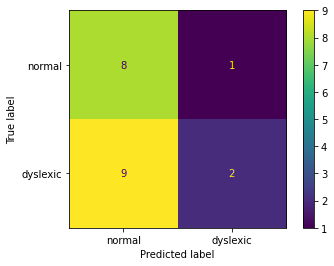

 ari: -0.032  presicion: 0.578  recall:0.500  f1-score: 0.434  auc roc:  0.535  tnr:  0.535 


In [160]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, ])


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [ ]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))




In [ ]:
shap_values = explainer(x_test)



In [ ]:


print("Shap values are determined!")




In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape




In [ ]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





In [ ]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





In [ ]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




In [ ]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [ ]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


